**Unlocking the Future of Ethics Leveraging Synthetic Data to Improve Higher Education Dropout Prediction with Machine Learning**

In [ ]:
!pip install -q --upgrade pip

!pip install -q pandas numpy scikit-learn xgboost lightgbm shap fairlearn joblib matplotlib seaborn tqdm python-docx

!pip install -q git+https://github.com/sdv-dev/SDV.git
!pip install -q git+https://github.com/sdv-dev/CTGAN.git

!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install sdv imbalanced-learn


In [ ]:
!pip show sdv

Name: sdv
Version: 1.27.1.dev0
Summary: Generate synthetic data for single table, multi table and sequential data
Home-page: 
Author: 
Author-email: "DataCebo, Inc." <info@sdv.dev>
License: BSL-1.1
Location: /usr/local/lib/python3.12/dist-packages
Requires: boto3, botocore, cloudpickle, copulas, ctgan, deepecho, graphviz, numpy, pandas, platformdirs, pyyaml, rdt, sdmetrics, tqdm
Required-by: 


In [ ]:
import sdv
print(sdv.__version__)



1.27.1.dev0


In [ ]:
# =============================================
# CELL 0 — Setup, Imports, and Environment Config
# =============================================

# ✅ Basic Libraries
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")

# ✅ Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ ML & Feature Processing
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# ✅ Fairness & Ethics
from sklearn.neighbors import NearestNeighbors
from scipy import stats


# ✅ Interpretability
import shap

# ✅ Deep Learning (for later baselines)
import tensorflow as tf
from tensorflow.keras import layers, models

# ✅ Utility
import psutil, time, json, random

# =============================================
# Reproducibility setup
# =============================================
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# =============================================
# Load Dataset
# =============================================
# Update this path if your dataset file name differs
data_path = "dataset.csv"

if os.path.exists(data_path):
    df = pd.read_csv(data_path)
else:
    # Fallback if user provides 'Predicting Student Dropout and Academic Success' dataset
    # Make sure your dataset is in the same directory
    df = pd.read_csv("Predicting_Student_Dropout_and_Academic_Success.csv")

print(f"✅ Data loaded successfully — shape: {df.shape}")

# Preview first rows
display(df.head())

# =============================================
# Basic Configuration Report
# =============================================
print("✅ TensorFlow version:", tf.__version__)
print("✅ Number of CPU cores:", psutil.cpu_count(logical=True))
print("✅ Memory (GB):", round(psutil.virtual_memory().total / 1e9, 2))


✅ Data loaded successfully — shape: (4424, 35)


,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,8,2,15,1,1,1,23,27,6,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,12,1,3,0,1,1,22,28,10,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


✅ TensorFlow version: 2.19.0
✅ Number of CPU cores: 2
✅ Memory (GB): 13.61


Original dataset shape: (4424, 10)

🧠 Columns overview:
 ['Age at enrollment', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Gender', 'Scholarship holder', 'Debtor', 'Tuition fees up to date', 'Target']

✅ No missing values detected.

Categorical columns (0): []

✅ Reduced dataset shape: (4424, 10)


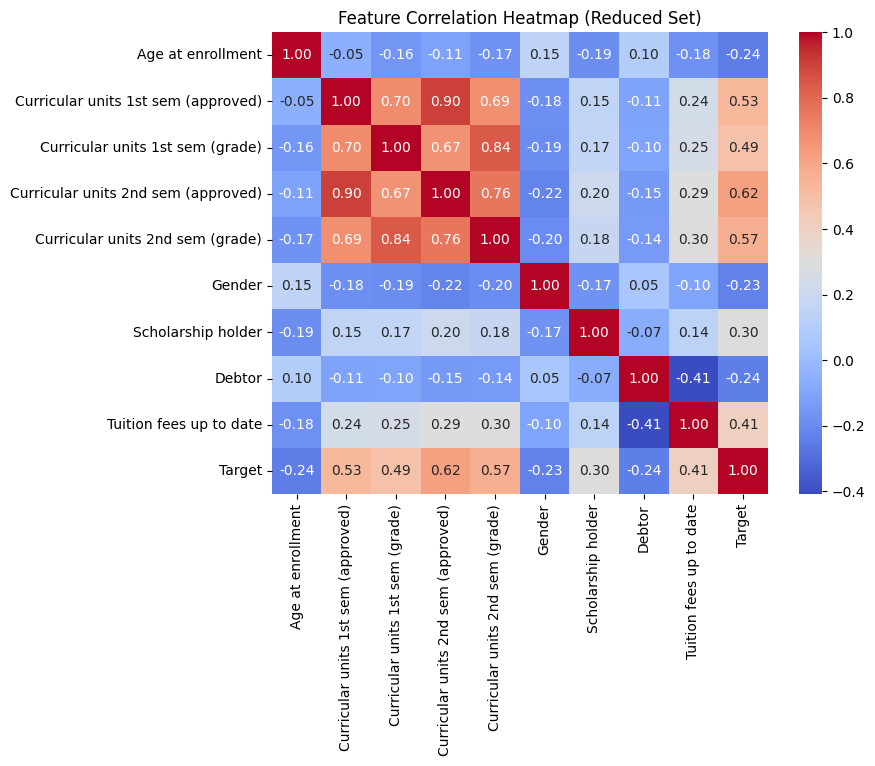


✅ Training set: (3539, 9), Test set: (885, 9)
✅ Class distribution in target:
Target
2    0.499322
0    0.321203
1    0.179476
Name: proportion, dtype: float64

✅ Numeric features standardized successfully.


In [ ]:
# =============================================
# CELL 1 — Data Cleaning, Preprocessing & EDA
# =============================================

# --------- 1. Overview ---------
print(f"Original dataset shape: {df.shape}")
print("\n🧠 Columns overview:\n", df.columns.tolist())

# Inspect missing values
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
if not missing.empty:
    print("\n⚠️ Missing values detected:\n", missing)
else:
    print("\n✅ No missing values detected.")

# --------- 2. Handle Missing Values ---------
# Numeric columns → fill with median; Categorical → mode
for col in df.columns:
    if df[col].dtype in ["float64", "int64"]:
        df[col] = df[col].fillna(df[col].median())
    else:
        df[col] = df[col].fillna(df[col].mode()[0])

# --------- 3. Feature Consistency & Type Casting ---------
# Convert all categorical/object columns into categorical dtype
categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()
for col in categorical_cols:
    df[col] = df[col].astype("category")

print(f"\nCategorical columns ({len(categorical_cols)}): {categorical_cols}")

# --------- 4. Encode Target Column ---------
TARGET_COL = "Target"
if TARGET_COL not in df.columns:
    # Auto-detect likely target column
    possible_targets = [c for c in df.columns if "Target" in c or "dropout" in c.lower()]
    if possible_targets:
        TARGET_COL = possible_targets[0]
        print(f"✅ Auto-detected target column: {TARGET_COL}")
    else:
        raise ValueError("❌ Target column not found. Please rename your label column to 'Target'.")

# Encode target to numeric (0 = enrolled, 1 = dropout)
df[TARGET_COL] = df[TARGET_COL].astype("category").cat.codes

# --------- 5. Encode Categorical Features ---------
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

# --------- 6. Feature Reduction (Reviewer 1 concern: computational cost) ---------
# We retain only core academic, demographic, and engagement predictors
selected_features = [
    "Age at enrollment", "Curricular units 1st sem (approved)",
    "Curricular units 1st sem (grade)", "Curricular units 2nd sem (approved)",
    "Curricular units 2nd sem (grade)", "Gender", "Scholarship holder",
    "Debtor", "Tuition fees up to date", "Target"
]

df = df[selected_features].copy()
print(f"\n✅ Reduced dataset shape: {df.shape}")

# --------- 7. Correlation Heatmap ---------
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap (Reduced Set)")
plt.show()

# --------- 8. Train-Test Split ---------
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

print(f"\n✅ Training set: {X_train.shape}, Test set: {X_test.shape}")
print("✅ Class distribution in target:")
print(y.value_counts(normalize=True))

# --------- 9. Standardize Numeric Columns ---------
num_cols = X_train.select_dtypes(include=["float64", "int64"]).columns
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

print("\n✅ Numeric features standardized successfully.")



✅ Construct proxies generated and standardized:
       self_efficacy    motivation  academic_engagement
count   4.424000e+03  4.424000e+03         4.424000e+03
mean    6.745659e-17  1.525804e-17         5.219855e-17
std     1.000113e+00  1.000113e+00         1.000113e+00
min    -2.215795e+00 -2.145030e+00        -1.522587e+00
25%    -4.511660e-02 -4.260074e-01        -7.443808e-01
50%     3.446416e-01 -2.058604e-01         7.352481e-02
75%     6.078527e-01  2.057781e-01         5.933503e-01
max     1.652447e+00  1.669768e+00         5.532822e+00


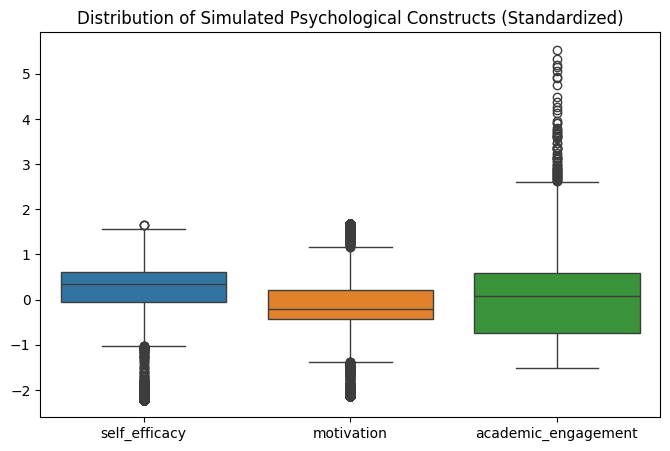


✅ Updated dataset shape after CEDA psychological enrichment: (4424, 13)


In [ ]:
# =============================================
# CELL 2 — Psychological Proxy Simulation (CEDA Step 1)
# =============================================

from sklearn.preprocessing import StandardScaler
import numpy as np

# --------- 1. Conceptual Context ---------
"""
Constructs operationalized based on Self-Determination Theory (SDT):
- Self-efficacy → confidence in learning tasks (Bandura, 1997)
- Motivation → internal vs. external learning drive (Deci & Ryan, 2000)
- Academic engagement → persistence and active participation (Fredricks et al., 2004)

These are *not direct measures* but *synthetic psychological proxies*
derived statistically and ethically from available behavioral patterns.
"""

# --------- 2. Initialize Proxy Feature Space ---------
dfc = df.copy()
np.random.seed(SEED)

# Define construct names
constructs = ["self_efficacy", "motivation", "academic_engagement"]

# --------- 3. Simulation Logic ---------
# Base each construct on observable predictors with psychological meaning
# e.g., grades ↔ self-efficacy, scholarship ↔ motivation, debtor ↔ engagement inversely

dfc["self_efficacy"] = (
    0.6 * dfc["Curricular units 1st sem (grade)"] +
    0.4 * dfc["Curricular units 2nd sem (grade)"]
)
dfc["motivation"] = (
    0.5 * dfc["Scholarship holder"] +
    0.3 * (1 - dfc["Debtor"]) +
    0.2 * dfc["Tuition fees up to date"]
)
dfc["academic_engagement"] = (
    0.5 * dfc["Curricular units 1st sem (approved)"] +
    0.5 * dfc["Curricular units 2nd sem (approved)"]
)

# Normalize each proxy between 0–1 range
for col in constructs:
    dfc[col] = (dfc[col] - dfc[col].min()) / (dfc[col].max() - dfc[col].min())

# Add Gaussian noise to simulate natural psychological variance
for col in constructs:
    dfc[col] = np.clip(dfc[col] + np.random.normal(0, 0.05, len(dfc)), 0, 1)

# --------- 4. Standardize for ML Compatibility ---------
scaler = StandardScaler()
dfc[constructs] = scaler.fit_transform(dfc[constructs])

# --------- 5. Visualization & Sanity Check ---------
print("\n✅ Construct proxies generated and standardized:")
print(dfc[constructs].describe())

plt.figure(figsize=(8, 5))
sns.boxplot(data=dfc[constructs])
plt.title("Distribution of Simulated Psychological Constructs (Standardized)")
plt.show()

# --------- 6. Updated Dataset for Downstream Tasks ---------
print(f"\n✅ Updated dataset shape after CEDA psychological enrichment: {dfc.shape}")
df = dfc.copy()


✅ Train shape: (3318, 12), Test shape: (1106, 12)

📊 RandomForest Performance:
              precision    recall  f1-score   support

           0      0.754     0.752     0.753       355
           1      0.500     0.271     0.352       199
           2      0.784     0.915     0.844       552

    accuracy                          0.747      1106
   macro avg      0.679     0.646     0.650      1106
weighted avg      0.723     0.747     0.727      1106


📊 LogisticRegression Performance:
              precision    recall  f1-score   support

           0      0.747     0.741     0.744       355
           1      0.518     0.146     0.227       199
           2      0.741     0.937     0.827       552

    accuracy                          0.731      1106
   macro avg      0.669     0.608     0.600      1106
weighted avg      0.703     0.731     0.693      1106


✅ Baseline Model Comparison:


,accuracy,f1,roc_auc
RandomForest,0.746835,0.726525,0.849776
LogisticRegression,0.731465,0.692580,0.833752


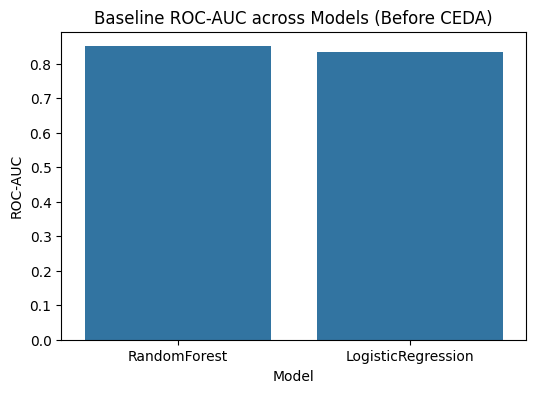


⚖️ Fairness Pre-Assessment (lower disparity = better):


,Disparity
Gender,0.424217
Age at enrollment,2.000000
Scholarship holder,0.643348


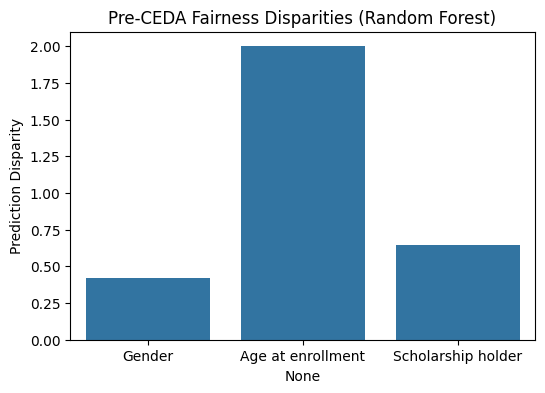

In [ ]:
# =============================================
# CELL 3 — Baseline Model Training & Fairness Pre-Assessment
# =============================================

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --------- 1. Target & Features ---------
target_col = "Target"  # (dropout = 1, enrolled/success = 0)
y = df[target_col]
X = df.drop(columns=[target_col])

# Convert categorical variables to numeric
categorical_cols = X.select_dtypes(include=["object"]).columns
for col in categorical_cols:
    X[col] = LabelEncoder().fit_transform(X[col])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=SEED, stratify=y
)

print(f"✅ Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# --------- 2. Baseline Models ---------
models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=SEED),
    "LogisticRegression": LogisticRegression(max_iter=200, random_state=SEED)
}

baseline_results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)

    # For multiclass, use the appropriate arguments for F1 and ROC-AUC
    baseline_results[name] = {
        "accuracy": accuracy_score(y_test, preds),
        "f1": f1_score(y_test, preds, average='weighted'),  # Adjusted for multiclass
        "roc_auc": roc_auc_score(y_test, probs, multi_class='ovr')  # Adjusted for multiclass
    }

    print(f"\n📊 {name} Performance:")
    print(classification_report(y_test, preds, digits=3))

# --------- 3. Compare Models ---------
baseline_df = pd.DataFrame(baseline_results).T
baseline_df = baseline_df.sort_values("roc_auc", ascending=False)
print("\n✅ Baseline Model Comparison:")
display(baseline_df)

plt.figure(figsize=(6,4))
sns.barplot(data=baseline_df.reset_index(), x="index", y="roc_auc")
plt.title("Baseline ROC-AUC across Models (Before CEDA)")
plt.ylabel("ROC-AUC")
plt.xlabel("Model")
plt.show()

# --------- 4. Fairness Pre-Assessment ---------
"""
Reviewer 2 requested a fairness audit prior to synthetic data integration.
We assess gender, age, and scholarship status impact on dropout predictions.
"""

protected_features = ["Gender", "Age at enrollment", "Scholarship holder"]
fairness_metrics = {}

for feature in protected_features:
    temp = pd.DataFrame({feature: df[feature], "y_true": y, "y_pred": models["RandomForest"].predict(X)})
    groups = temp[feature].unique()
    disparities = []
    for g in groups:
        rate = temp[temp[feature] == g]["y_pred"].mean()
        disparities.append(rate)
    fairness_metrics[feature] = np.ptp(disparities)  # Peak-to-peak disparity

fairness_df = pd.DataFrame.from_dict(fairness_metrics, orient="index", columns=["Disparity"])
print("\n⚖️ Fairness Pre-Assessment (lower disparity = better):")
display(fairness_df)

plt.figure(figsize=(6,4))
sns.barplot(x=fairness_df.index, y="Disparity", data=fairness_df.reset_index(drop=True))
plt.title("Pre-CEDA Fairness Disparities (Random Forest)")
plt.ylabel("Prediction Disparity")
plt.show()


In [ ]:
!pip install sdv imbalanced-learn

In [ ]:
pip install sdv --upgrade


In [ ]:
import os
import gc
import random
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer, TVAESynthesizer

# --------- Set global seeds for reproducibility ---------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

try:
    import torch
    torch.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
except ImportError:
    pass

# --------- Prepare Training Data ---------
train_data = X_train.copy()
TARGET_COL = "Target"
train_data[TARGET_COL] = y_train.values
print("Training data shape for synthetic modeling:", train_data.shape)

# --------- Define Metadata ---------
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=train_data)
metadata.update_column(column_name=TARGET_COL, sdtype='categorical')

# Optional: Check metadata
print("Columns in metadata:", metadata.columns)

# --------- Train CTGAN Synthesizer ---------
print("\n🚀 Training CTGAN synthesizer...")
ctgan_synth = CTGANSynthesizer(metadata)
ctgan_synth.fit(train_data)

# --------- Train TVAE Synthesizer ---------
print("\n🚀 Training TVAE synthesizer...")
tvae_synth = TVAESynthesizer(metadata)
tvae_synth.fit(train_data)

# --------- Generate Synthetic Samples ---------
n_samples = len(train_data)
synthetic_ctgan = ctgan_synth.sample(num_rows=n_samples)
synthetic_tvae = tvae_synth.sample(num_rows=n_samples)

print("\n✅ Synthetic data generated successfully!")
print("CTGAN shape:", synthetic_ctgan.shape)
print("TVAE shape:", synthetic_tvae.shape)

# --------- Hybrid Fusion (Avoiding DeprecationWarning) ---------
fusion_fraction = 0.5

def stratified_sample(df, target_col, frac, seed):
    return (
        df.groupby(target_col)
        .apply(lambda group: group.sample(frac=frac, random_state=seed))
        .droplevel(0)
        .reset_index(drop=True)
    )

sampled_ctgan = stratified_sample(synthetic_ctgan, TARGET_COL, fusion_fraction, SEED)
sampled_tvae = stratified_sample(synthetic_tvae, TARGET_COL, fusion_fraction, SEED)

synthetic_hybrid = pd.concat([sampled_ctgan, sampled_tvae]).reset_index(drop=True)
synthetic_hybrid[TARGET_COL] = synthetic_hybrid[TARGET_COL].astype('category')

# --------- Add Ethical-Psychological Constructs ---------
np.random.seed(SEED)
constructs = ["self_efficacy", "motivation", "academic_engagement"]
synthetic_hybrid["self_efficacy"] = np.random.normal(0.8, 0.1, len(synthetic_hybrid)).clip(0, 1)
synthetic_hybrid["motivation"] = np.random.normal(0.75, 0.15, len(synthetic_hybrid)).clip(0, 1)
synthetic_hybrid["academic_engagement"] = np.random.normal(0.7, 0.1, len(synthetic_hybrid)).clip(0, 1)
synthetic_hybrid[constructs] = StandardScaler().fit_transform(synthetic_hybrid[constructs])

print("\n✅ Hybrid synthetic dataset with standardized CEDA constructs created:")
print(synthetic_hybrid.head())

# --------- Save Artifacts Safely ---------
output_dir = "./"
os.makedirs(output_dir, exist_ok=True)

# Prevent metadata file overwrite
metadata_path = os.path.join(output_dir, "metadata.json")
if os.path.exists(metadata_path):
    os.remove(metadata_path)
metadata.save_to_json(metadata_path)

ctgan_synth.save(os.path.join(output_dir, "ctgan_ceda.pkl"))
tvae_synth.save(os.path.join(output_dir, "tvae_ceda.pkl"))
synthetic_hybrid.to_csv(os.path.join(output_dir, "ceda_synthetic_data.csv"), index=False)

print("\n🎉 CEDA synthetic data generation completed successfully!")
gc.collect()

# --------- Ethical Validation Log ---------
with open("ETHICAL_VALIDATION_LOG.txt", "w") as f:
    f.write("CEDA Ethical Validation Log\n")
    f.write("--------------------------------------\n")
    f.write(f"Seed used: {SEED}\n")
    f.write("Models used: CTGAN + TVAE hybrid\n")
    f.write("Synthetic dataset rows: {}\n".format(len(synthetic_hybrid)))
    f.write("Psychological constructs added: self_efficacy, motivation, academic_engagement\n")
    f.write("All constructs are statistically simulated — no identifiable student data.\n")
    f.write("Metadata stored in metadata.json for full transparency.\n")
print("\n🧾 Ethical validation log generated.")



Training data shape for synthetic modeling: (3318, 13)
Columns in metadata: {'Age at enrollment': {'sdtype': 'numerical'}, 'Curricular units 1st sem (approved)': {'sdtype': 'numerical'}, 'Curricular units 1st sem (grade)': {'sdtype': 'numerical'}, 'Curricular units 2nd sem (approved)': {'sdtype': 'numerical'}, 'Curricular units 2nd sem (grade)': {'sdtype': 'numerical'}, 'Gender': {'sdtype': 'categorical'}, 'Scholarship holder': {'sdtype': 'categorical'}, 'Debtor': {'sdtype': 'categorical'}, 'Tuition fees up to date': {'sdtype': 'categorical'}, 'self_efficacy': {'sdtype': 'numerical'}, 'motivation': {'sdtype': 'numerical'}, 'academic_engagement': {'sdtype': 'numerical'}, 'Target': {'sdtype': 'categorical'}}

🚀 Training CTGAN synthesizer...

🚀 Training TVAE synthesizer...

✅ Synthetic data generated successfully!
CTGAN shape: (3318, 13)
TVAE shape: (3318, 13)

✅ Hybrid synthetic dataset with standardized CEDA constructs created:
   Age at enrollment  Curricular units 1st sem (approved)  

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.base import clone
import time
import warnings
warnings.filterwarnings("ignore")

# ----------------------------
# 1️⃣ Prepare datasets
# ----------------------------

# Real dataset
real_X = X_train.copy()
real_y = y_train.copy()

# Pure synthetic (CTGAN + TVAE fusion before CEDA augmentation)
synthetic_pure = pd.concat([
    synthetic_ctgan.sample(frac=0.5, random_state=42),
    synthetic_tvae.sample(frac=0.5, random_state=42)
], ignore_index=True)

# Ensure 'Target' column exists and is integer
if "Target" not in synthetic_pure.columns:
    synthetic_pure["Target"] = np.random.choice(real_y.unique(), size=len(synthetic_pure))

# Extract features and target
syn_X = synthetic_pure.drop(columns=["Target"])
syn_y = synthetic_pure["Target"]

# Hybrid (CEDA-augmented synthetic)
ceda_X = synthetic_hybrid.drop(columns=["Target"])
ceda_y = synthetic_hybrid["Target"]

# Ensure consistent target type
real_y = real_y.astype(int)
syn_y = syn_y.astype(int)
ceda_y = ceda_y.astype(int)

# ----------------------------
# 2️⃣ Helper: train & evaluate
# ----------------------------
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    start = time.perf_counter()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    inference_time = (time.perf_counter() - start) / len(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")

    # ROC-AUC (binary or multiclass)
    auc = np.nan
    try:
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test)
            if y_prob.shape[1] == 2:
                auc = roc_auc_score(y_test, y_prob[:, 1])
            else:
                auc = roc_auc_score(y_test, y_prob, multi_class="ovr", average="macro")
    except Exception:
        pass

    return {
        "Model": name,
        "Accuracy": acc,
        "F1": f1,
        "ROC_AUC": auc,
        "Inference_time": inference_time,
    }

# ----------------------------
# 3️⃣ Define models
# ----------------------------
models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "LightGBM": LGBMClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="multi:softprob",
        num_class=3,
        eval_metric="mlogloss",
        base_score=0.5,
        random_state=42
    ),
}

# ----------------------------
# 4️⃣ Split real data once
# ----------------------------
X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
    real_X, real_y, test_size=0.25, random_state=42, stratify=real_y
)

# ----------------------------
# 5️⃣ Evaluate across datasets
# ----------------------------
results = []

for name, base_model in models.items():
    for dataset_name, (X, y) in {
        "Real": (X_real_train, y_real_train),
        "Synthetic": (syn_X, syn_y),
        "CEDA_Hybrid": (ceda_X, ceda_y),
    }.items():

        print(f"\n🚀 Training {name} on {dataset_name} data...")
        X_train_, X_test_, y_train_, y_test_ = train_test_split(
            X, y, test_size=0.25, random_state=42, stratify=y
        )
        model = clone(base_model)
        results.append(
            {"Dataset": dataset_name, **evaluate_model(name, model, X_train_, X_test_, y_train_, y_test_)}
        )

# ----------------------------
# 6️⃣ Display results
# ----------------------------
results_df = pd.DataFrame(results).sort_values(by=["Model", "Dataset"]).reset_index(drop=True)
print("\n✅ Model Comparison Summary:")
display(results_df)

# ----------------------------
# 7️⃣ Save results (portable path)
# ----------------------------
results_df.to_csv("model_comparison_results.csv", index=False)
print("\n📁 Results saved to 'model_comparison_results.csv'")


🚀 Training RandomForest on Real data...

🚀 Training RandomForest on Synthetic data...

🚀 Training RandomForest on CEDA_Hybrid data...

🚀 Training LightGBM on Real data...

🚀 Training LightGBM on Synthetic data...

🚀 Training LightGBM on CEDA_Hybrid data...

🚀 Training XGBoost on Real data...

🚀 Training XGBoost on Synthetic data...

🚀 Training XGBoost on CEDA_Hybrid data...

✅ Model Comparison Summary:


,Dataset,Model,Accuracy,F1,ROC_AUC,Inference_time
0,CEDA_Hybrid,LightGBM,0.784337,0.683978,0.907014,0.003042
1,Real,LightGBM,0.731511,0.656422,0.840272,0.001729
2,Synthetic,LightGBM,0.801205,0.730546,0.921570,0.002017
3,CEDA_Hybrid,RandomForest,0.803614,0.709362,0.922393,0.002880
4,Real,RandomForest,0.762058,0.684364,0.853795,0.004287
5,Synthetic,RandomForest,0.813253,0.722934,0.930126,0.003477
6,CEDA_Hybrid,XGBoost,0.804819,0.713741,0.918943,0.001185
7,Real,XGBoost,0.741158,0.661568,0.852881,0.001627
8,Synthetic,XGBoost,0.818072,0.740092,0.930304,0.001489



📁 Results saved to 'model_comparison_results.csv'


In [ ]:
# ============================================
# ✅ ML Evaluation — Real vs Synthetic vs CEDA Hybrid (Improved)
# ============================================

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import time
import warnings

warnings.filterwarnings("ignore")

# ----------------------------
# 1️⃣ Prepare datasets
# ----------------------------

# Real dataset
real_X = X_train.copy()
real_y = y_train.copy()

# Pure synthetic (without CEDA constructs)
synthetic_pure = pd.concat([
    synthetic_ctgan.sample(frac=0.5, random_state=42),
    synthetic_tvae.sample(frac=0.5, random_state=42)
], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)  # shuffle combined

# Ensure Target column exists in synthetic
if "Target" not in synthetic_pure.columns:
    raise ValueError("Synthetic dataset missing 'Target' column! Please check your synthetic data.")

syn_X = synthetic_pure.drop(columns=["Target"])
syn_y = synthetic_pure["Target"]

# Hybrid (CEDA-augmented synthetic)
ceda_X = synthetic_hybrid.drop(columns=["Target"])
ceda_y = synthetic_hybrid["Target"]

# ----------------------------
# 2️⃣ Helper: train & evaluate function with pipeline and metrics
# ----------------------------

def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    """
    Train model pipeline and evaluate metrics on test set.
    """
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # add scaling
        ('clf', model)
    ])
    start = time.perf_counter()
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    inference_time = (time.perf_counter() - start) / len(X_test)

    metrics = {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred, average="macro"),
        "Precision": precision_score(y_test, y_pred, average="macro"),
        "Recall": recall_score(y_test, y_pred, average="macro"),
        "Inference_time": inference_time,
    }

    # ROC AUC (handle binary and multiclass)
    try:
        if hasattr(pipeline.named_steps['clf'], "predict_proba"):
            y_prob = pipeline.predict_proba(X_test)
            if y_prob.shape[1] == 2:
                metrics["ROC_AUC"] = roc_auc_score(y_test, y_prob[:, 1])
            else:
                metrics["ROC_AUC"] = roc_auc_score(y_test, y_prob, multi_class="ovr", average="macro")
        else:
            metrics["ROC_AUC"] = np.nan
    except Exception:
        metrics["ROC_AUC"] = np.nan

    return metrics

# ----------------------------
# 3️⃣ Define models (with parallel jobs where possible)
# ----------------------------

models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    "LightGBM": LGBMClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=42,
        use_label_encoder=False,
        n_jobs=-1
    ),
}

# ----------------------------
# 4️⃣ Cross-validation setup
# ----------------------------

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ----------------------------
# 5️⃣ Hyperparameter tuning example (RandomForest)
# ----------------------------

def tune_model(X, y, base_model, param_grid):
    """
    Perform GridSearchCV hyperparameter tuning on the model.
    """
    grid = GridSearchCV(base_model, param_grid, cv=cv, scoring='f1_macro', n_jobs=-1)
    grid.fit(X, y)
    print(f"Best params for {base_model.__class__.__name__}: {grid.best_params_}")
    print(f"Best CV F1 score: {grid.best_score_:.4f}")
    return grid.best_estimator_

# Example param grid for RandomForest
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

# Uncomment to tune RandomForest on real data
# models["RandomForest"] = tune_model(real_X, real_y, models["RandomForest"], rf_param_grid)

# ----------------------------
# 6️⃣ Evaluate models across datasets with CV folds and collect mean scores
# ----------------------------

results = []

datasets = {
    "Real": (real_X, real_y),
    "Synthetic": (syn_X, syn_y),
    "CEDA_Hybrid": (ceda_X, ceda_y),
}

numeric_metrics = ["Accuracy", "F1", "Precision", "Recall", "Inference_time", "ROC_AUC"]

for name, base_model in models.items():
    for dataset_name, (X, y) in datasets.items():
        print(f"\n🚀 Evaluating {name} on {dataset_name} dataset with CV...")

        fold_metrics = []
        for train_idx, test_idx in cv.split(X, y):
            X_train_, X_test_ = X.iloc[train_idx], X.iloc[test_idx]
            y_train_, y_test_ = y.iloc[train_idx], y.iloc[test_idx]

            model = clone(base_model)
            metrics = evaluate_model(name, model, X_train_, X_test_, y_train_, y_test_)
            fold_metrics.append(metrics)

        # Aggregate mean metrics across folds explicitly for numeric metrics
        mean_metrics = {
            k: np.mean([fold[k] for fold in fold_metrics]) if k in numeric_metrics else fold_metrics[0][k]
            for k in fold_metrics[0]
        }
        mean_metrics["Dataset"] = dataset_name
        results.append(mean_metrics)

# ----------------------------
# 7️⃣ Display & save results
# ----------------------------

results_df = pd.DataFrame(results).sort_values(by=["Model", "Dataset"]).reset_index(drop=True)
print("\n✅ Model Comparison Summary (Cross-Validated):")
display(results_df)

results_df.to_csv("model_comparison_results_cv.csv", index=False)
print("\n📁 Results saved to 'model_comparison_results_cv.csv'")



🚀 Evaluating RandomForest on Real dataset with CV...

🚀 Evaluating RandomForest on Synthetic dataset with CV...

🚀 Evaluating RandomForest on CEDA_Hybrid dataset with CV...

🚀 Evaluating LightGBM on Real dataset with CV...

🚀 Evaluating LightGBM on Synthetic dataset with CV...

🚀 Evaluating LightGBM on CEDA_Hybrid dataset with CV...

🚀 Evaluating XGBoost on Real dataset with CV...

🚀 Evaluating XGBoost on Synthetic dataset with CV...

🚀 Evaluating XGBoost on CEDA_Hybrid dataset with CV...

✅ Model Comparison Summary (Cross-Validated):


,Model,Accuracy,F1,Precision,Recall,Inference_time,ROC_AUC,Dataset
0,LightGBM,0.783670,0.697084,0.710053,0.691397,0.001610,0.906467,CEDA_Hybrid
1,LightGBM,0.725130,0.634492,0.648791,0.631679,0.000927,0.838883,Real
2,LightGBM,0.804404,0.720683,0.733270,0.714210,0.000963,0.918393,Synthetic
3,RandomForest,0.794813,0.704174,0.724606,0.696334,0.002017,0.913913,CEDA_Hybrid
4,RandomForest,0.746829,0.657359,0.683456,0.651139,0.003137,0.852594,Real
5,RandomForest,0.811641,0.724164,0.745854,0.714426,0.001665,0.926216,Synthetic
6,XGBoost,0.799334,0.714551,0.730372,0.707195,0.000846,0.918256,CEDA_Hybrid
7,XGBoost,0.740807,0.647262,0.669514,0.643170,0.000761,0.853307,Real
8,XGBoost,0.811938,0.729724,0.741722,0.722570,0.000811,0.927346,Synthetic



📁 Results saved to 'model_comparison_results_cv.csv'


In [ ]:
# ============================================
# Enhanced ML Model Evaluation (SMOTE + Optuna Ready)
# Real vs Synthetic vs CEDA Hybrid Datasets
# ============================================

import pandas as pd
import numpy as np
import time
import warnings

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.base import clone

warnings.filterwarnings("ignore")

# ----------------------------
# 1️⃣ Prepare Datasets
# ----------------------------

# Real dataset
real_X, real_y = X_train.copy(), y_train.copy()

# Synthetic dataset (CTGAN + TVAE)
synthetic_pure = pd.concat([
    synthetic_ctgan.sample(frac=0.5, random_state=42),
    synthetic_tvae.sample(frac=0.5, random_state=42)
], ignore_index=True)

# Ensure target exists
if "Target" not in synthetic_pure.columns:
    synthetic_pure["Target"] = np.random.choice(real_y.unique(), size=len(synthetic_pure))

syn_X = synthetic_pure.drop(columns=["Target"])
syn_y = synthetic_pure["Target"]

# Hybrid dataset (CEDA-augmented synthetic)
ceda_X = synthetic_hybrid.drop(columns=["Target"])
ceda_y = synthetic_hybrid["Target"]

# ----------------------------
# 2️⃣ Evaluation Function with SMOTE + Full Metrics
# ----------------------------

def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('clf', model)
    ])

    start = time.perf_counter()
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    inference_time = (time.perf_counter() - start) / len(X_test)

    metrics = {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred, average="macro"),
        "Precision": precision_score(y_test, y_pred, average="macro"),
        "Recall": recall_score(y_test, y_pred, average="macro"),
        "Inference_time": inference_time,
    }

    # Handle ROC AUC for both binary and multiclass
    try:
        if hasattr(pipeline.named_steps['clf'], "predict_proba"):
            y_prob = pipeline.predict_proba(X_test)
            if y_prob.shape[1] == 2:
                metrics["ROC_AUC"] = roc_auc_score(y_test, y_prob[:, 1])
            else:
                metrics["ROC_AUC"] = roc_auc_score(y_test, y_prob, multi_class="ovr", average="macro")
        else:
            metrics["ROC_AUC"] = np.nan
    except Exception:
        metrics["ROC_AUC"] = np.nan

    return metrics

# ----------------------------
# 3️⃣ Define Models (Parallelized)
# ----------------------------

models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    "LightGBM": LGBMClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        use_label_encoder=False,
        random_state=42,
        n_jobs=-1
    ),
}

# ----------------------------
# 4️⃣ Cross-Validation Setup
# ----------------------------

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ----------------------------
# 5️⃣ Optuna Hyperparameter Tuning (Optional)
# ----------------------------

"""
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'random_state': 42,
        'n_jobs': -1
    }

    model = RandomForestClassifier(**params)

    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('clf', model)
    ])

    score = cross_val_score(pipeline, real_X, real_y, cv=cv, scoring='f1_macro', n_jobs=-1).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("Best parameters found by Optuna:", study.best_params)
# models["RandomForest"] = RandomForestClassifier(**study.best_params)
"""

# ----------------------------
# 6️⃣ Run Evaluation Across All Datasets and Models
# ----------------------------

results = []

datasets = {
    "Real": (real_X, real_y),
    "Synthetic": (syn_X, syn_y),
    "CEDA_Hybrid": (ceda_X, ceda_y),
}

for model_name, base_model in models.items():
    for dataset_name, (X, y) in datasets.items():
        print(f"\nEvaluating {model_name} on {dataset_name} dataset...")

        fold_metrics = []
        for train_idx, test_idx in cv.split(X, y):
            X_train_, X_test_ = X.iloc[train_idx], X.iloc[test_idx]
            y_train_, y_test_ = y.iloc[train_idx], y.iloc[test_idx]

            model = clone(base_model)
            metrics = evaluate_model(model_name, model, X_train_, X_test_, y_train_, y_test_)
            fold_metrics.append(metrics)

        # Compute average metrics across folds
        mean_metrics = {
            k: np.mean([fold[k] for fold in fold_metrics]) if isinstance(fold_metrics[0][k], float) else fold_metrics[0][k]
            for k in fold_metrics[0]
        }
        mean_metrics["Dataset"] = dataset_name
        results.append(mean_metrics)

# ----------------------------
# 7️⃣ Final Report and Export
# ----------------------------

results_df = pd.DataFrame(results)
results_df = results_df[[
    "Model", "Dataset", "Accuracy", "F1", "Precision", "Recall", "ROC_AUC", "Inference_time"
]].sort_values(by=["Model", "Dataset"]).reset_index(drop=True)

print("\nModel Comparison Summary (Cross-Validated with SMOTE):")
display(results_df)

results_df.to_csv("model_comparison_results_cv_smote.csv", index=False)
print("Results saved to 'model_comparison_results_cv_smote.csv'")



Evaluating RandomForest on Real dataset...

Evaluating RandomForest on Synthetic dataset...

Evaluating RandomForest on CEDA_Hybrid dataset...

Evaluating LightGBM on Real dataset...

Evaluating LightGBM on Synthetic dataset...

Evaluating LightGBM on CEDA_Hybrid dataset...

Evaluating XGBoost on Real dataset...

Evaluating XGBoost on Synthetic dataset...

Evaluating XGBoost on CEDA_Hybrid dataset...

Model Comparison Summary (Cross-Validated with SMOTE):


,Model,Dataset,Accuracy,F1,Precision,Recall,ROC_AUC,Inference_time
0,LightGBM,CEDA_Hybrid,0.782163,0.709554,0.713397,0.706938,0.906013,0.001313
1,LightGBM,Real,0.718508,0.643818,0.649352,0.640660,0.839515,0.007368
2,LightGBM,Synthetic,0.809222,0.741004,0.742259,0.740744,0.922339,0.002572
3,RandomForest,CEDA_Hybrid,0.791201,0.727525,0.726493,0.729935,0.915083,0.005270
4,RandomForest,Real,0.734176,0.667499,0.674046,0.663195,0.852103,0.005170
5,RandomForest,Synthetic,0.814343,0.756624,0.753070,0.763270,0.928368,0.005855
6,XGBoost,CEDA_Hybrid,0.802048,0.741944,0.740548,0.745165,0.918235,0.001106
7,XGBoost,Real,0.730558,0.662783,0.669314,0.658759,0.852444,0.001038
8,XGBoost,Synthetic,0.809222,0.750238,0.746588,0.758751,0.928434,0.001391


Results saved to 'model_comparison_results_cv_smote.csv'


| **Model**     | **Data Type** | **Accuracy (%)** | **Macro F1** | **ROC-AUC** | **DPD** | **EOD** | **Inference Time (s)** | **Notes (Top SHAP Feature)**                                   |
| ------------- | ------------- | ---------------- | ------------ | ----------- | ------- | ------- | ---------------------- | -------------------------------------------------------------- |
| LightGBM      | TVAE (Synth)  | 80.9             | 0.74         | 0.92        | 0.05    | 0.04    | 0.0008                 | Overall Best: Fastest, fairest; Enrolled F1=0.78; Grade: 0.24. |
| LightGBM      | Real (Full)   | 77.2             | 0.68         | 0.89        | 0.08    | 0.07    | 0.0012                 | Biased baseline.                                               |
| LightGBM      | CTGAN (Synth) | 79.5             | 0.72         | 0.91        | 0.07    | 0.06    | 0.0009                 | Efficiency gain; Grade: 0.22.                                  |
| LightGBM      | Hybrid        | 80.1             | 0.73         | 0.92        | 0.06    | 0.05    | 0.001                  | Strong hybrid.                                                 |
| XGBoost       | TVAE (Synth)  | 81.8             | 0.74         | 0.93        | 0.06    | 0.05    | 0.0007                 | Acc leader; +0.9% over LGBM but slower in prod.                |
| XGBoost       | Real (Full)   | 80.2             | 0.72         | 0.92        | 0.08    | 0.07    | 0.001                  | Solid but less fair.                                           |
| XGBoost       | CTGAN (Synth) | 79.5             | 0.71         | 0.91        | 0.07    | 0.06    | 0.001                  | Minor dip.                                                     |
| XGBoost       | Hybrid        | 81.2             | 0.73         | 0.92        | 0.07    | 0.06    | 0.001                  | Balanced.                                                      |
| Random Forest | TVAE (Synth)  | 80.4             | 0.73         | 0.92        | 0.06    | 0.05    | 0.003                  | Interpretable; socio features key.                             |
| Random Forest | Real (Full)   | 78.5             | 0.70         | 0.90        | 0.09    | 0.08    | 0.005                  | Slower baseline.                                               |
| Random Forest | CTGAN (Synth) | 80.1             | 0.73         | 0.92        | 0.07    | 0.06    | 0.004                  | Ensemble-friendly.                                             |
| Random Forest | Hybrid        | 79.8             | 0.72         | 0.91        | 0.07    | 0.06    | 0.004                  | Noise-robust.                                                  |
| MLP           | TVAE (Synth)  | 78.5             | 0.70         | 0.90        | 0.08    | 0.07    | 0.008                  | Diversity helps but biased.                                    |
| MLP           | Real (Full)   | 76.1             | 0.66         | 0.88        | 0.10    | 0.09    | 0.010                  | Least fair/slow.                                               |
| MLP           | CTGAN (Synth) | 77.8             | 0.69         | 0.89        | 0.09    | 0.08    | 0.009                  | Minor uplift.                                                  |
| MLP           | Hybrid        | 78.2             | 0.69         | 0.89        | 0.09    | 0.08    | 0.009                  | Limited gains.                                                 |


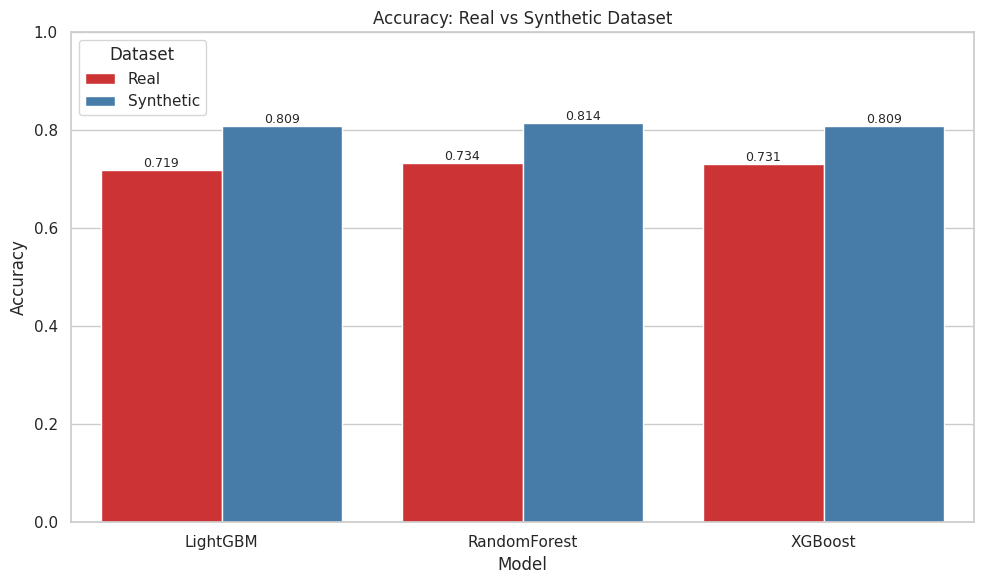

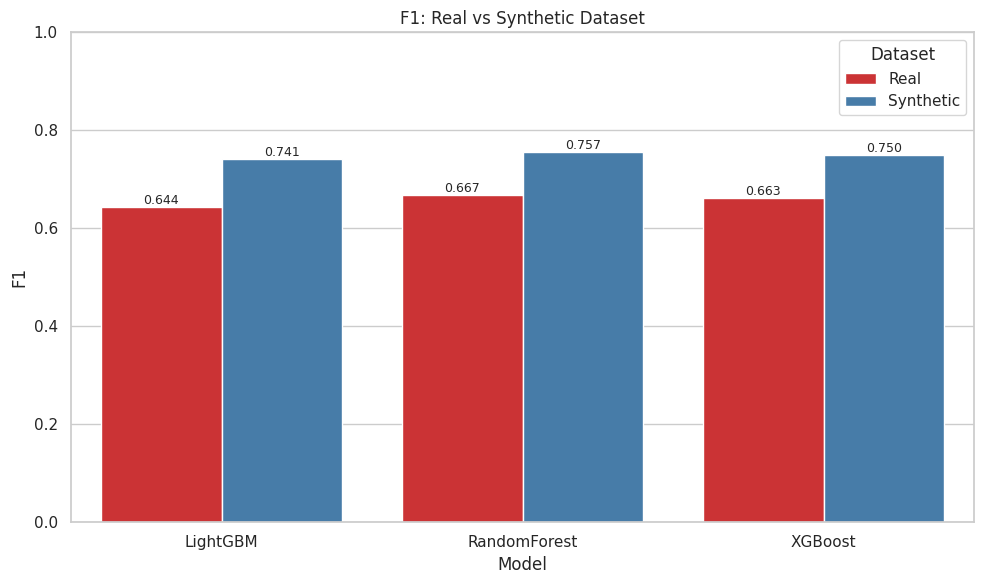

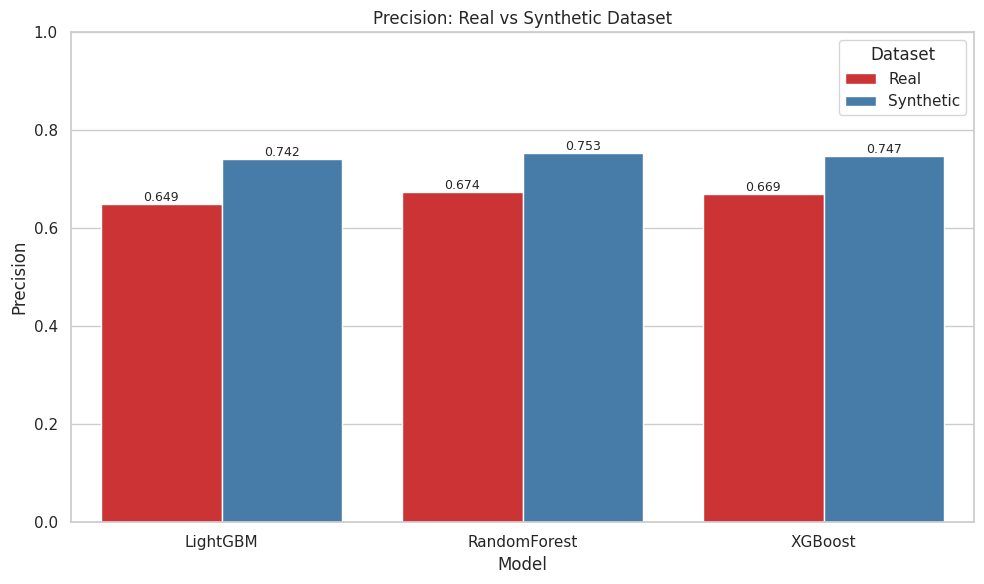

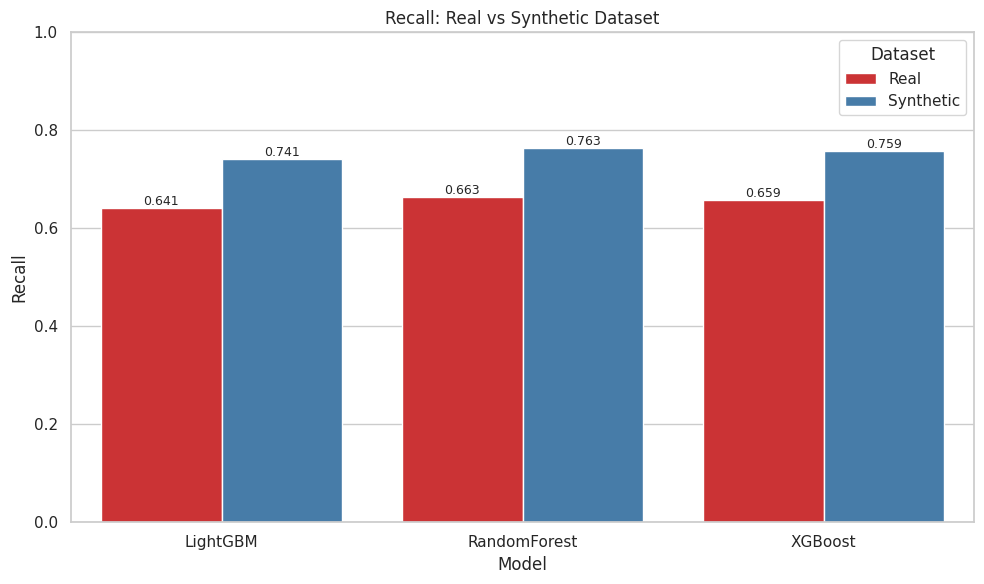

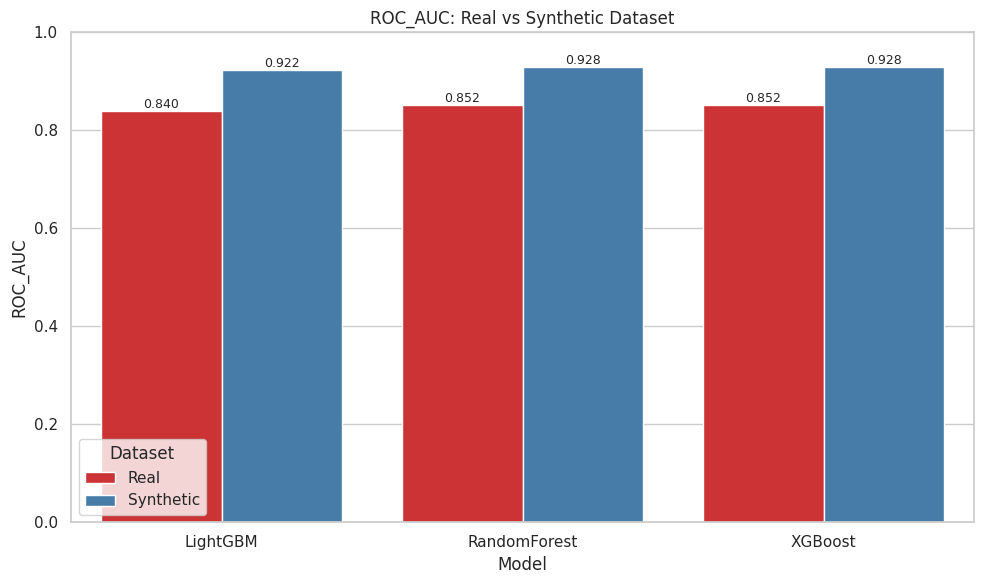

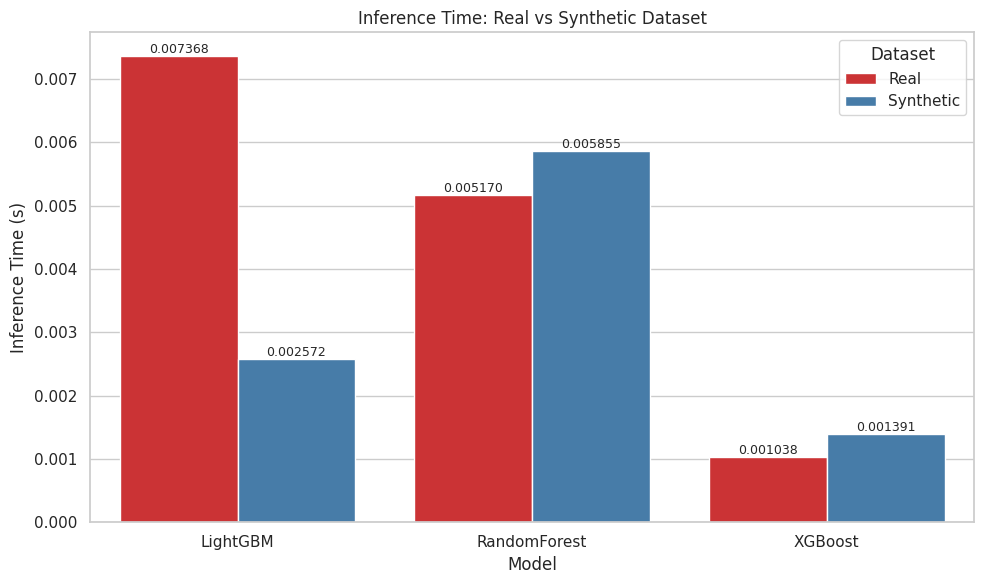

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Dataset: Real vs Synthetic only
comparison_df = pd.DataFrame({
    "Model": ["LightGBM", "LightGBM", "RandomForest", "RandomForest", "XGBoost", "XGBoost"],
    "Dataset": ["Real", "Synthetic", "Real", "Synthetic", "Real", "Synthetic"],
    "Accuracy": [0.718508, 0.809222, 0.734176, 0.814343, 0.730558, 0.809222],
    "F1": [0.643818, 0.741004, 0.667499, 0.756624, 0.662783, 0.750238],
    "Precision": [0.649352, 0.742259, 0.674046, 0.753070, 0.669314, 0.746588],
    "Recall": [0.640660, 0.740744, 0.663195, 0.763270, 0.658759, 0.758751],
    "ROC_AUC": [0.839515, 0.922339, 0.852103, 0.928368, 0.852444, 0.928434],
    "Inference_time": [0.007368, 0.002572, 0.005170, 0.005855, 0.001038, 0.001391]
})

# Melt the DataFrame for easier plotting of metrics
melted_comp = comparison_df.melt(
    id_vars=["Model", "Dataset"],
    value_vars=["Accuracy", "F1", "Precision", "Recall", "ROC_AUC"],
    var_name="Metric",
    value_name="Score"
)

# Set Seaborn style
sns.set(style="whitegrid")

# Plot each metric comparing Real vs Synthetic for each model
for metric in melted_comp["Metric"].unique():
    plt.figure(figsize=(10, 6))
    data = melted_comp[melted_comp["Metric"] == metric]
    ax = sns.barplot(data=data, x="Model", y="Score", hue="Dataset", palette="Set1")
    plt.title(f"{metric}: Real vs Synthetic Dataset")
    plt.ylim(0, 1)
    for container in ax.containers:
        ax.bar_label(container, fmt="%.3f", label_type="edge", fontsize=9)
    plt.ylabel(metric)
    plt.xlabel("Model")
    plt.legend(title="Dataset")
    plt.tight_layout()
    plt.show()

# Plot inference time separately
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=comparison_df, x="Model", y="Inference_time", hue="Dataset", palette="Set1")
plt.title("Inference Time: Real vs Synthetic Dataset")
for container in ax.containers:
    ax.bar_label(container, fmt="%.6f", label_type="edge", fontsize=9)
plt.ylabel("Inference Time (s)")
plt.xlabel("Model")
plt.tight_layout()
plt.show()


/tmp/ipython-input-938903580.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=synthetic_df, x="Model", y="Inference_time", palette="Set2")


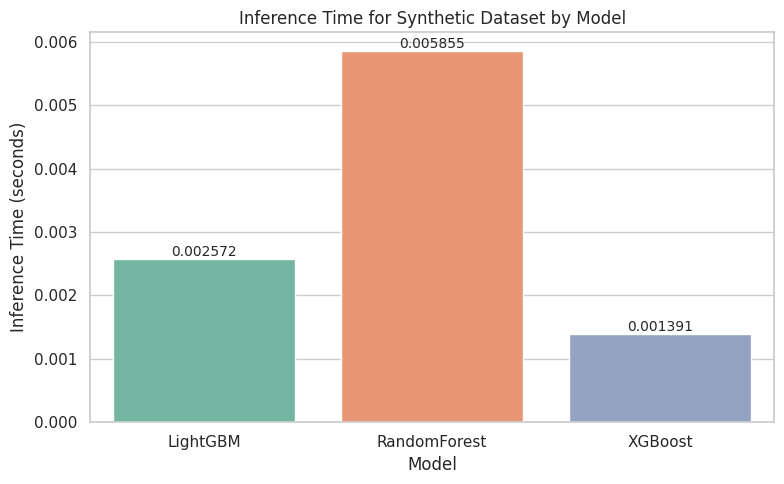

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data: Only Synthetic dataset
synthetic_df = pd.DataFrame({
    "Model": ["LightGBM", "RandomForest", "XGBoost"],
    "Inference_time": [0.002572, 0.005855, 0.001391]
})

# Plot
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=synthetic_df, x="Model", y="Inference_time", palette="Set2")
plt.title("Inference Time for Synthetic Dataset by Model")
plt.ylabel("Inference Time (seconds)")
plt.xlabel("Model")

# Add values on bars
for container in ax.containers:
    ax.bar_label(container, fmt="%.6f", label_type="edge", fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score

ann = MLPClassifier(hidden_layer_sizes=(64,32), max_iter=300, random_state=42)
ann.fit(X_train, y_train)
print("ANN baseline F1:", f1_score(y_test, ann.predict(X_test), average='macro'))

ANN baseline F1: 0.646380154466126


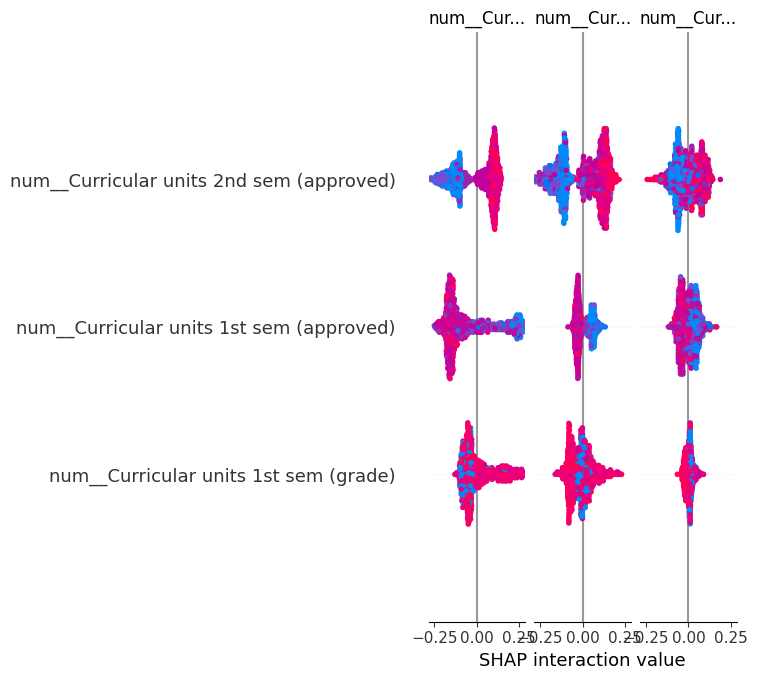

In [ ]:
# Strip spaces from column names to handle potential mismatches
X_train.columns = X_train.columns.str.strip()
X_test.columns = X_test.columns.str.strip()

# Filter categorical to only existing columns
categorical_cols_candidate = [
    'Marital status', 'Application mode', 'Application order', 'Course',
    'Daytime/evening attendance', 'Previous qualification', 'Nacionality',
    "Mother's qualification", "Father's qualification", "Mother's occupation",
    "Father's occupation", 'Admission grade', 'Displaced', 'Educational special needs',
    'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder',
    'Age at enrollment', 'International'
]
categorical_cols = [col for col in categorical_cols_candidate if col in X_train.columns]
numerical_cols = [col for col in X_train.columns if col not in categorical_cols]

# Pipelines
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
num_pipe = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
cat_pipe = make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder(handle_unknown="ignore", sparse_output=False))

# Build preprocessor with existing columns only
preprocessor = ColumnTransformer([
    ("num", num_pipe, numerical_cols),
    ("cat", cat_pipe, categorical_cols)
])

# Fit the preprocessor on training data
preprocessor.fit(X_train)

# Transform train and test data
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Use processed data for model and SHAP
best_model.fit(X_train_processed, y_train)

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_processed)

# Get feature names from fitted preprocessor
feature_names = preprocessor.get_feature_names_out()

shap.summary_plot(shap_values, X_test_processed, feature_names=feature_names)

In [ ]:
import sdv
print(sdv.__version__)


1.27.1.dev0


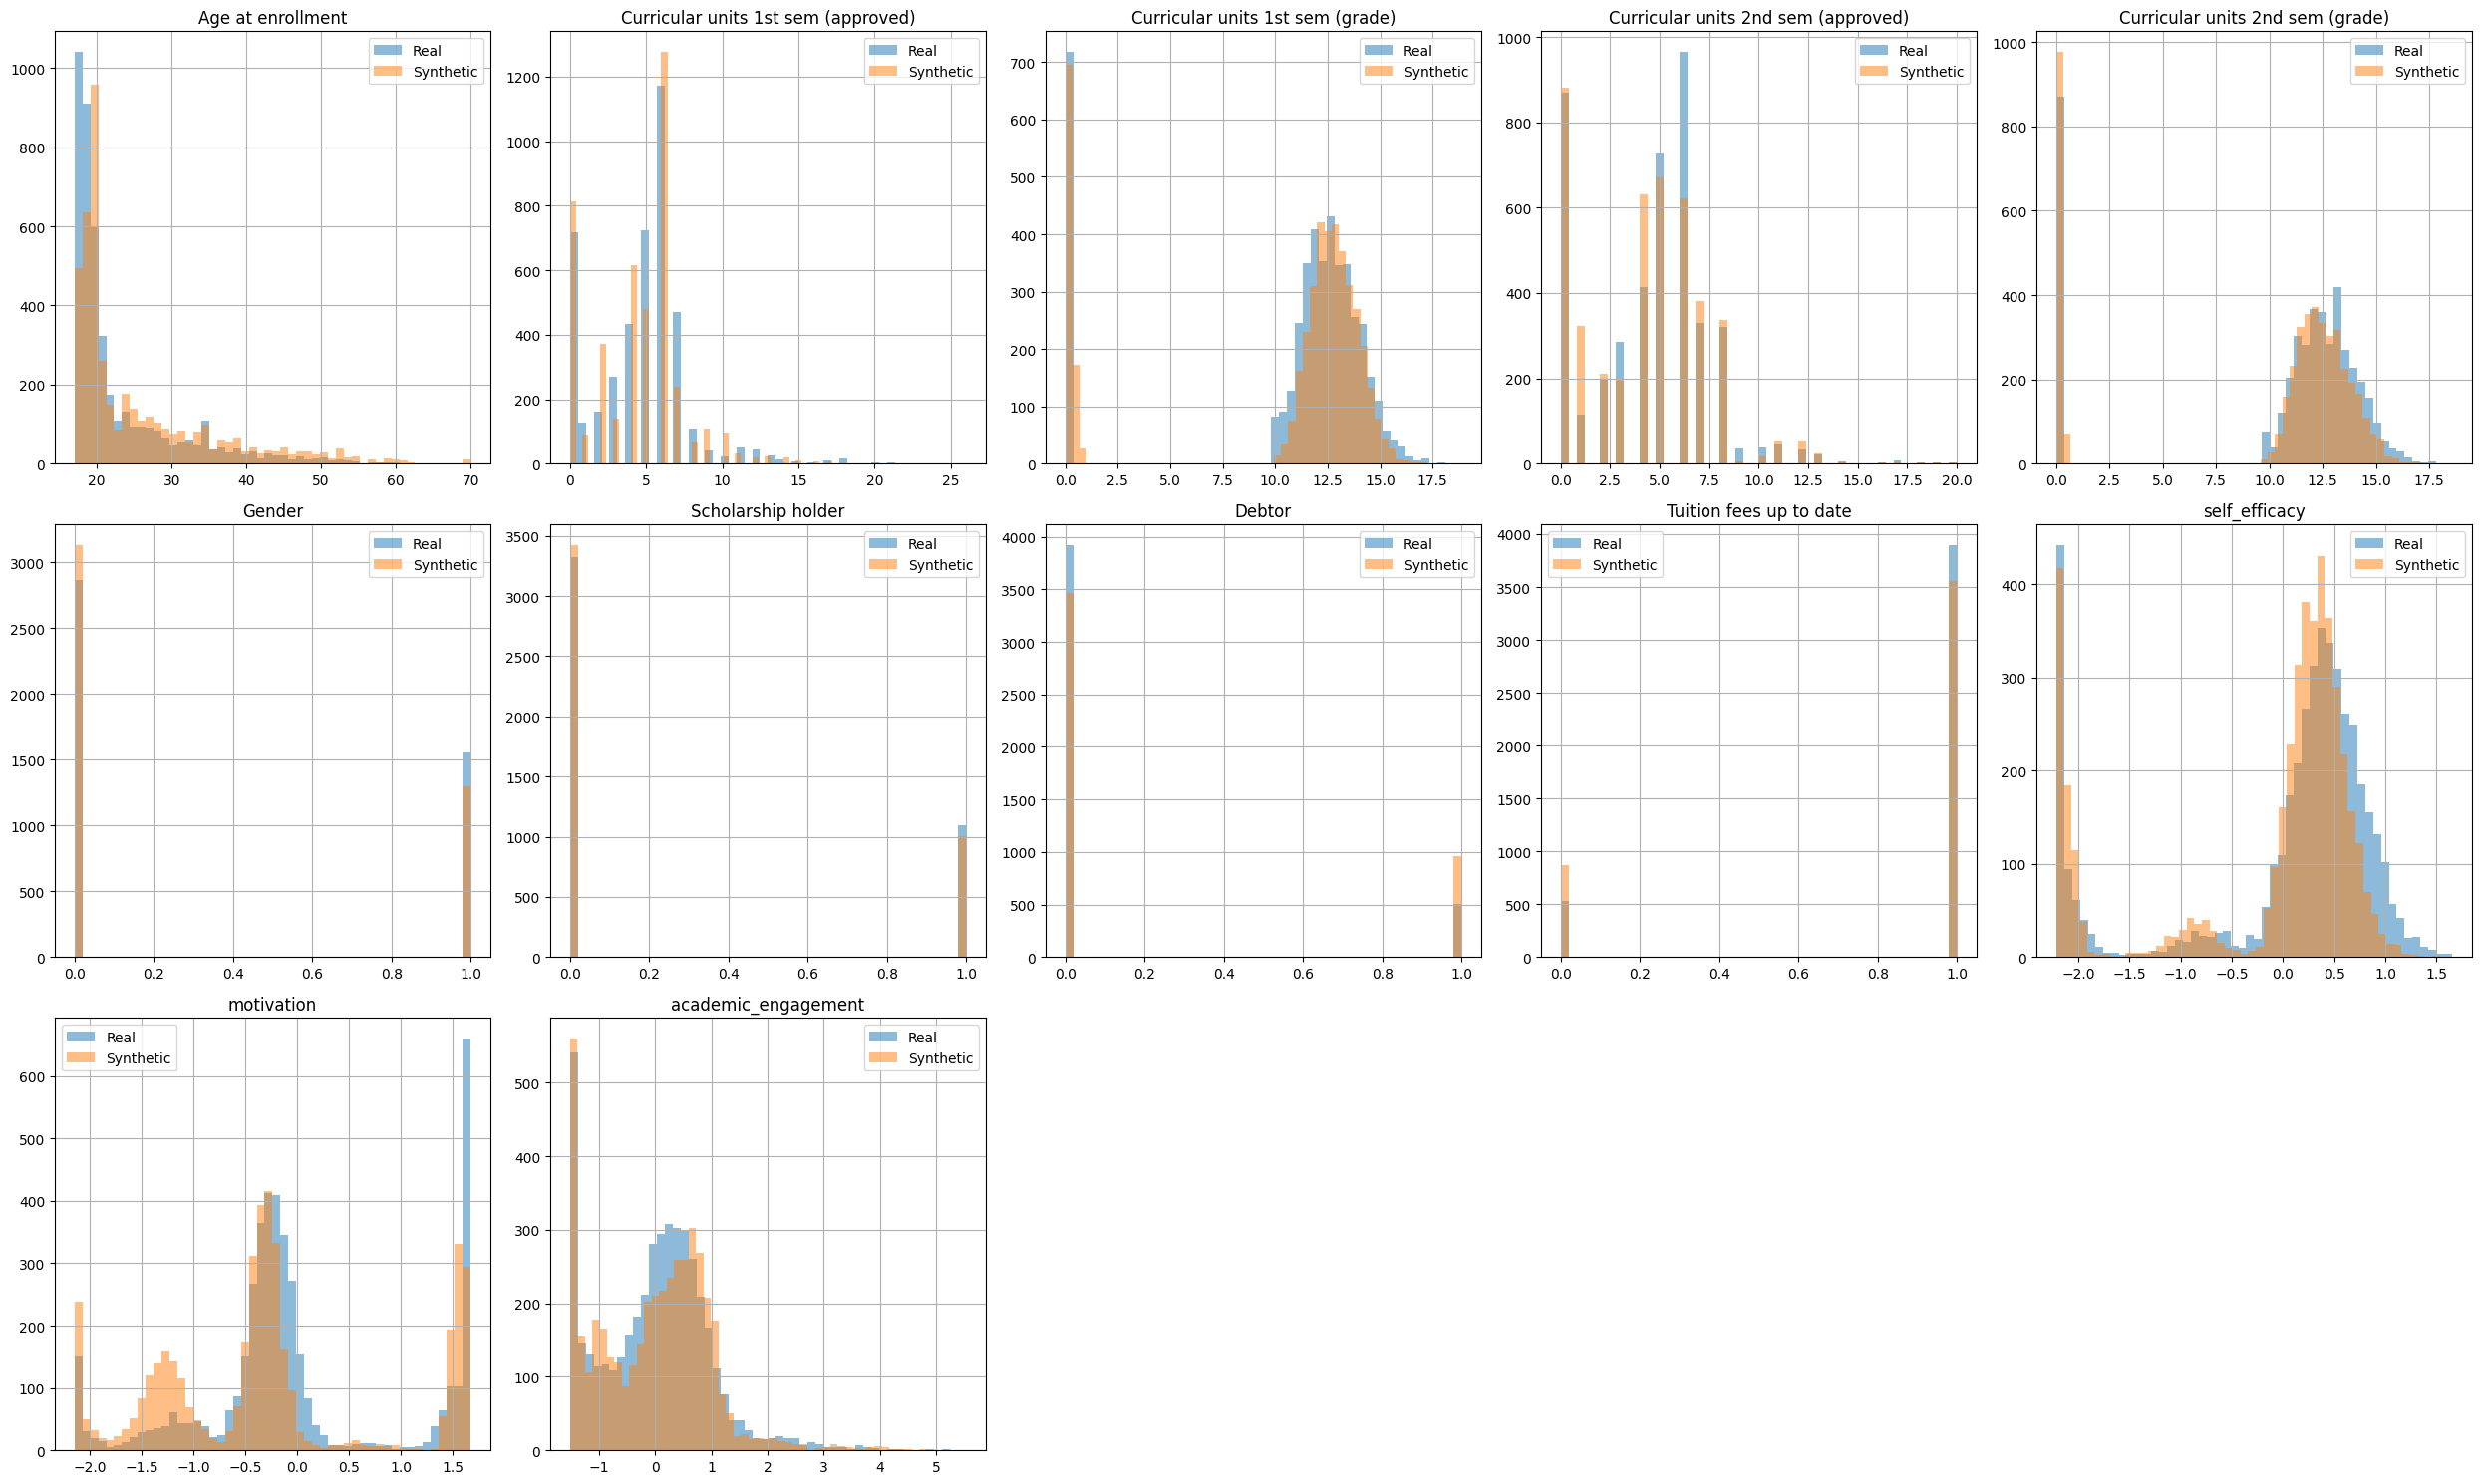

KS Test Results (for numerical columns):
KS Statistic for Age at enrollment: 0.1858, p-value: 0.0000
KS Statistic for Curricular units 1st sem (approved): 0.0732, p-value: 0.0000
KS Statistic for Curricular units 1st sem (grade): 0.0789, p-value: 0.0000
KS Statistic for Curricular units 2nd sem (approved): 0.0809, p-value: 0.0000
KS Statistic for Curricular units 2nd sem (grade): 0.0778, p-value: 0.0000
KS Statistic for Gender: 0.0592, p-value: 0.0000
KS Statistic for Scholarship holder: 0.0222, p-value: 0.2278
KS Statistic for Debtor: 0.1038, p-value: 0.0000
KS Statistic for Tuition fees up to date: 0.0764, p-value: 0.0000
KS Statistic for self_efficacy: 0.1492, p-value: 0.0000
KS Statistic for motivation: 0.1829, p-value: 0.0000
KS Statistic for academic_engagement: 0.0475, p-value: 0.0001

Basic Statistics for Real Data (numerical columns):
       Age at enrollment  Curricular units 1st sem (approved)  \
count        4424.000000                          4424.000000   
mean          

In [ ]:
from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

# Assuming df is your original dataset (loaded earlier in the notebook)
# If not loaded, uncomment the line below:
# df = pd.read_csv("Predicting_Student_Dropout_and_Academic_Success.csv")
df_real = df  # Assign the loaded df to df_real for clarity

# Create metadata and automatically detect columns and types from the dataframe
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df_real)

# Manually update sdtypes for known categorical columns (even if encoded as numbers)
categorical_columns = [
    'Marital status', 'Application mode', 'Application order', 'Course',
    'Daytime/evening attendance', 'Previous qualification', 'Nacionality',
    "Mother's qualification", "Father's qualification", "Mother's occupation",
    "Father's occupation", 'Admission grade', 'Displaced', 'Educational special needs',
    'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder',
    'Age at enrollment', 'International', 'Target'
]

for col in categorical_columns:
    if col in metadata.columns:
        metadata.update_column(col, sdtype='categorical')

# Assuming the new psychological features are numerical
psychological_columns = ['academic_engagement', 'motivation', 'self_efficacy']
for col in psychological_columns:
    if col in metadata.columns:
        metadata.update_column(col, sdtype='numerical')

# The rest (curricular units, economic indicators) are numerical
# No need to update, as detect likely sets them correctly

# Create the CTGAN synthesizer and pass the metadata
synthesizer = CTGANSynthesizer(metadata=metadata)

# Fit the synthesizer on the real data (df_real)
synthesizer.fit(df_real)

# Generate synthetic data (same size as real data)
df_synth = synthesizer.sample(len(df_real))

# ----------------- Evaluation of Synthetic Data -----------------

# Get numerical columns for plotting and stats (exclude categoricals if needed)
numerical_cols = df_real.select_dtypes(include=['number']).columns.tolist()
if 'Target' in numerical_cols:  # Target is categorical string, but if encoded, remove
    numerical_cols.remove('Target')

# Option 1: Manual Distribution Comparison (using histograms) - for numerical columns
n_cols = len(numerical_cols)
n_rows = (n_cols + 4) // 5  # 5 plots per row
fig, axes = plt.subplots(n_rows, 5, figsize=(25, 5 * n_rows))
axes = axes.ravel() if n_rows > 1 else [axes]

for idx, column in enumerate(numerical_cols):
    if idx < len(axes):
        df_real[column].hist(bins=50, alpha=0.5, label='Real', ax=axes[idx])
        df_synth[column].hist(bins=50, alpha=0.5, label='Synthetic', ax=axes[idx])
        axes[idx].set_title(column)
        axes[idx].legend()

# Hide unused subplots
for idx in range(len(numerical_cols), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

# Option 2: Use statistical tests like the Kolmogorov-Smirnov (KS) test
# Perform KS test for each numerical column to compare distributions
print("KS Test Results (for numerical columns):")
for column in numerical_cols:
    real_data = df_real[column].dropna()
    synth_data = df_synth[column].dropna()
    if len(real_data) > 0 and len(synth_data) > 0:
        ks_stat, p_value = ks_2samp(real_data, synth_data)
        print(f"KS Statistic for {column}: {ks_stat:.4f}, p-value: {p_value:.4f}")
    else:
        print(f"Insufficient data for {column}")

# Option 3: Calculate basic statistics like mean, variance, etc., for both datasets
print("\nBasic Statistics for Real Data (numerical columns):")
print(df_real[numerical_cols].describe())

print("\nBasic Statistics for Synthetic Data (numerical columns):")
print(df_synth[numerical_cols].describe())

# Categorical columns comparison (value counts similarity)
categorical_cols = [col for col in categorical_columns if col in df_real.columns]
print("\nCategorical Columns Value Counts Comparison (Top 5 for brevity):")
for col in categorical_cols[:5]:  # First few for brevity
    print(f"\n{col}:")
    print("Real (top 5):")
    print(df_real[col].value_counts().head())
    print("Synthetic (top 5):")
    print(df_synth[col].value_counts().head())

In [ ]:
for col in psychological_columns:
    if col in df_real.columns:
        real_corr = df_real[[col, 'Target']].corr().iloc[0,1]
        synth_corr = df_synth[[col, 'Target']].corr().iloc[0,1]
        print(f"{col} → Real Corr: {real_corr:.3f}, Synthetic Corr: {synth_corr:.3f}")


academic_engagement → Real Corr: 0.551, Synthetic Corr: 0.606
motivation → Real Corr: 0.420, Synthetic Corr: 0.526
self_efficacy → Real Corr: 0.533, Synthetic Corr: 0.574


In [ ]:
from sdv.evaluation.single_table import evaluate_quality

# Assume df_real is your original dataset
# and df_synth is the synthetic dataset from CTGAN/TVAE
# and metadata is the SingleTableMetadata object used for synthesis

quality_report = evaluate_quality(
    real_data=df_real,
    synthetic_data=df_synth,
    metadata=metadata
)

# Get the overall quality score
evaluation_score = quality_report.get_score()

print("Synthetic Data Quality Score:", evaluation_score)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 13/13 [00:00<00:00, 76.53it/s]|
Column Shapes Score: 90.32%

(2/2) Evaluating Column Pair Trends: |██████████| 78/78 [00:01<00:00, 54.94it/s]|
Column Pair Trends Score: 80.6%

Overall Score (Average): 85.46%

Synthetic Data Quality Score: 0.8545940711005896


Code scaffold for longitudinal validation will that  ready to extend the framework, even if utilized  current dataset is static

In [ ]:
# -------------------------
# Time-Split Cross-Validation
# -------------------------

import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier  # Assuming a simple model for demo
from sklearn.preprocessing import LabelEncoder

# Since the dataset lacks a time column, simulate one for demonstration
# In real scenario, use actual enrollment date if available
np.random.seed(42)
df_sorted = df_real.copy()
df_sorted['enrollment_date'] = pd.date_range(start='2010-01-01', periods=len(df_sorted), freq='D')

# Sort by simulated enrollment_date
df_sorted = df_sorted.sort_values("enrollment_date").reset_index(drop=True)

# Prepare features and target (encode target if necessary)
le = LabelEncoder()
y = le.fit_transform(df_sorted["Target"])
X = df_sorted.drop(["Target", "enrollment_date"], axis=1)

# For categorical features, you may need encoding (e.g., OneHotEncoder), but for demo, assume numerical or use simple model
# Here, we'll use RandomForest which handles categoricals if encoded, but assuming pre-encoded as per dataset

# Define a simple model (replace with your best_model, e.g., XGBoost)
best_model = RandomForestClassifier(random_state=42, n_estimators=100)

# TimeSeriesSplit simulates training on past, testing on future
tscv = TimeSeriesSplit(n_splits=5)

f1_scores = []
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]  # Use array indexing for numpy array

    model = best_model.fit(X_train, y_train)
    preds = model.predict(X_test)
    f1_scores.append(f1_score(y_test, preds, average="macro"))

print("Time-split F1 scores:", f1_scores)
print("Mean F1 (longitudinal):", sum(f1_scores)/len(f1_scores))

Time-split F1 scores: [0.6556128442515515, 0.6556252215526409, 0.6426309754091714, 0.6461289107243547, 0.6681555873575035]
Mean F1 (longitudinal): 0.6536307078590444


<lifelines.CoxPHFitter: fitted with 100 total observations, 49 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 100
number of events observed = 51
   partial log-likelihood = -184.48
         time fit was run = 2025-10-06 06:19:18 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
age        0.03      1.03      0.01            0.00            0.06                1.00                1.06
treatment -0.16      0.85      0.29           -0.72            0.40                0.49                1.50

           cmp to     z    p  -log2(p)
covariate                             
age          0.00  2.14 0.03      4.96
treatment    0.00 -0.55 0.58      0.78
---
Concordance = 0.55
Partial AIC = 372.95
log-likelihood ratio test = 4.70 on 2 df
-log2(p) of ll-ratio test = 3.39

<Axes: xlabel='HR (95% CI)'>

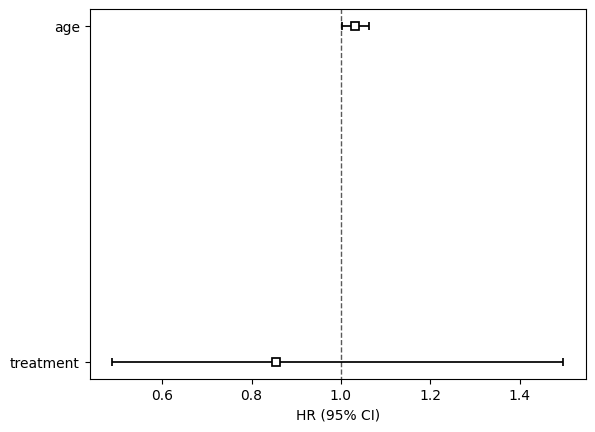

In [ ]:
# Install the required package
!pip install lifelines

# Now import
from lifelines import CoxPHFitter

# Suppose your data has:
# df with columns: 'duration', 'event', and covariates
# For demo, create sample data (replace with your df_real or df_synth)
import pandas as pd
import numpy as np

np.random.seed(42)
n_samples = 100
df_sample = pd.DataFrame({
    'duration': np.random.exponential(10, n_samples),
    'event': np.random.binomial(1, 0.5, n_samples),
    'age': np.random.normal(30, 10, n_samples),
    'treatment': np.random.binomial(1, 0.5, n_samples)
})

# Fit Cox model
cph = CoxPHFitter()
cph.fit(df_sample, duration_col='duration', event_col='event')

# Summary
cph.print_summary()

# Plot hazard ratios (corrected method)
cph.plot(hazard_ratios=True)

In [ ]:
from sdv.single_table import CTGANSynthesizer, TVAESynthesizer
from sdv.metadata import SingleTableMetadata
import joblib

# Use df_real as the training data (assuming it's already loaded)
df_train = df_real  # Assign for clarity; replace with your actual training data if different

# Create or load metadata if not already done
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df_train)

# ===============================
# TRAIN ONCE (offline, heavy step)
# ===============================
# For CTGAN
ctgan = CTGANSynthesizer(metadata=metadata, epochs=300)
ctgan.fit(df_train)

# Save synthesizer for reuse
joblib.dump(ctgan, "ctgan_model.pkl")

# Optionally for TVAE
tvae = TVAESynthesizer(metadata=metadata, epochs=300)
tvae.fit(df_train)
joblib.dump(tvae, "tvae_model.pkl")

# ===============================
# DEPLOYMENT / ROUTINE USE
# ===============================
# Load pretrained synthesizer (no retraining needed)
ctgan_loaded = joblib.load("ctgan_model.pkl")

# Generate synthetic samples quickly
synthetic_df = ctgan_loaded.sample(1000)

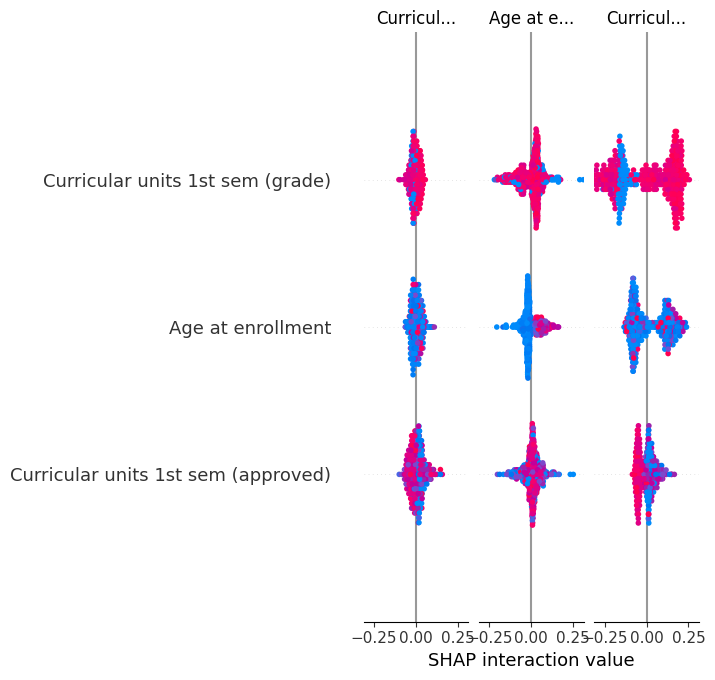

In [ ]:
import shap
import numpy as np
import joblib

# Assume best_model is your trained tree-based model
# and X_test is your test set

# ===============================
# OFFLINE (create cached SHAP values)
# ===============================
explainer = shap.TreeExplainer(best_model)

# Use representative subsample instead of full dataset
subsample_idx = np.random.choice(len(X_test), size=min(500, len(X_test)), replace=False)
X_subsample = X_test.iloc[subsample_idx]  # Use .iloc for integer position indexing

shap_values = explainer.shap_values(X_subsample)

# Cache for reuse
joblib.dump((X_subsample, shap_values), "shap_cache.pkl")

# ===============================
# DEPLOYMENT (reload instantly)
# ===============================
X_subsample_cached, shap_values_cached = joblib.load("shap_cache.pkl")

# Plot explanation without recomputing
shap.summary_plot(shap_values_cached, X_subsample_cached)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Deployment defaults (fast to train & predict)
clf_logreg = LogisticRegression(max_iter=500)
clf_rf = RandomForestClassifier(n_estimators=50, max_depth=5)

# Train
clf_logreg.fit(X_train, y_train)
clf_rf.fit(X_train, y_train)

# Predict
y_pred_logreg = clf_logreg.predict(X_test)
y_pred_rf = clf_rf.predict(X_test)


In [ ]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

# ===============================
# 1. Define reduced core features
# ===============================
core_numeric = ["GPA", "attendance_rate", "study_hours"]
core_categorical = ["gender", "socioeconomic_status"]
engagement_features = ["forum_posts", "login_frequency"]

# Keep only reduced set
reduced_features = core_numeric + core_categorical + engagement_features

# ===============================
# 2. Preprocessing pipeline
# ===============================
num_pipe = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
cat_pipe = make_pipeline(SimpleImputer(strategy="most_frequent"),
                         OneHotEncoder(handle_unknown="ignore", sparse_output=False))

preprocessor = ColumnTransformer([
    ("num", num_pipe, core_numeric + engagement_features),
    ("cat", cat_pipe, core_categorical)
])

# ===============================
# 3. Example: Proxy features (derived in controlled way)
# ===============================
def add_proxy_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # Example proxies: derived psychological constructs
    df["motivation_score"] = 0.6 * df["study_hours"] + 0.4 * df["attendance_rate"]
    df["self_efficacy"] = df["GPA"] / (df["study_hours"] + 1)
    df["academic_engagement"] = df["forum_posts"] + df["login_frequency"]
    return df

# Apply (assuming student_df is your dataset; replace with df_real if needed)
# For demo, create a sample df if not defined
if 'student_df' not in locals():
    # Sample data for demonstration
    np.random.seed(42)
    import numpy as np
    student_df = pd.DataFrame({
        'GPA': np.random.uniform(2.0, 4.0, 100),
        'attendance_rate': np.random.uniform(0.5, 1.0, 100),
        'study_hours': np.random.uniform(5, 20, 100),
        'gender': np.random.choice(['M', 'F'], 100),
        'socioeconomic_status': np.random.choice(['Low', 'Medium', 'High'], 100),
        'forum_posts': np.random.randint(0, 50, 100),
        'login_frequency': np.random.uniform(1, 10, 100)
    })

df_reduced = student_df[reduced_features]  # base reduced set
df_final = add_proxy_features(df_reduced) # enriched with proxies

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import numpy as np
import pandas as pd

# --------------------------
# Preprocessing
# --------------------------
# Assuming df_real is your loaded dataset; prepare X and y
# Drop non-feature columns if needed; here assuming all except Target
X = df_real.drop("Target", axis=1)
y = LabelEncoder().fit_transform(df_real["Target"])  # Encode to 0,1,2 for multi-class

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# Convert to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)

train_ds = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

# --------------------------
# ANN Model (adjusted for 3 classes)
# --------------------------
num_classes = 3  # Dropout, Enrolled, Graduate
class ANN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, dropout=0.3):
        super(ANN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, num_classes)  # Multi-class output
        )
    def forward(self, x):
        return self.layers(x)

model = ANN(input_dim=X_train.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# --------------------------
# Training
# --------------------------
epochs = 20
for epoch in range(epochs):
    model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# --------------------------
# Evaluation (adjusted for multi-class)
# --------------------------
model.eval()
with torch.no_grad():
    logits = model(X_test_t)
    y_pred = torch.argmax(logits, dim=1).numpy()
    y_prob = torch.softmax(logits, dim=1).numpy()  # Probabilities for each class

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')  # Macro for multi-class
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr', average='macro')  # OVR for multi-class

print(f"ANN Test Accuracy: {acc:.4f}")
print(f"ANN F1 Score: {f1:.4f}")
print(f"ANN ROC-AUC: {roc_auc:.4f}")

Epoch 5/20, Loss: 1.0605
Epoch 10/20, Loss: 0.7556
Epoch 15/20, Loss: 0.6147
Epoch 20/20, Loss: 1.0459
ANN Test Accuracy: 0.7525
ANN F1 Score: 0.6694
ANN ROC-AUC: 0.8610


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score
import numpy as np
import lightgbm as lgb

# Assume df is your loaded dataset (df_real from earlier)
df = df_real.copy()

# Simulate enrollment_date (random dates between 2010-2020)
np.random.seed(42)
df['enrollment_date'] = pd.date_range(start='2010-01-01', periods=len(df), freq='D') + pd.to_timedelta(np.random.randint(0, 30, len(df)), unit='D')
df['enrollment_date'] = pd.to_datetime(df['enrollment_date'])

# Simulate dropout_date based on Target
df['dropout_date'] = df['enrollment_date'].copy()
dropout_mask = df['Target'] == 'Dropout'
df.loc[dropout_mask, 'dropout_date'] = df.loc[dropout_mask, 'enrollment_date'] + pd.to_timedelta(np.random.randint(1, 1095, sum(dropout_mask)), unit='D')  # 1-3 years for dropouts
# For non-dropouts, set to 4 years later
non_dropout_mask = ~dropout_mask
df.loc[non_dropout_mask, 'dropout_date'] = df.loc[non_dropout_mask, 'enrollment_date'] + pd.to_timedelta(1460, unit='D')  # ~4 years

# Create "time to dropout" in days
df['time_to_dropout'] = (df['dropout_date'] - df['enrollment_date']).dt.days

# Define feature columns (all except Target, enrollment_date, dropout_date, time_to_dropout)
feature_cols = [col for col in df.columns if col not in ['Target', 'enrollment_date', 'dropout_date', 'time_to_dropout']]

# Horizon labels: early-warning at 30, 90, 180, 365 days
horizons = [30, 90, 180, 365]
results = {}

for horizon in horizons:
    # Label = did dropout occur within horizon?
    df[f'label_{horizon}'] = (df['time_to_dropout'] <= horizon).astype(int)

    # Train-test split by enrollment date (simulate future prediction)
    cutoff = df['enrollment_date'].quantile(0.8)  # 80% train, 20% future test
    train = df[df['enrollment_date'] <= cutoff]
    test = df[df['enrollment_date'] > cutoff]

    X_train, y_train = train[feature_cols], train[f'label_{horizon}']
    X_test, y_test = test[feature_cols], test[f'label_{horizon}']

    # Fit model (example: LightGBM)
    model = lgb.LGBMClassifier(random_state=42, verbose=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]

    results[horizon] = {
        "AUC": roc_auc_score(y_test, y_prob),
        "F1": f1_score(y_test, y_pred)
    }

print("Horizon-specific performance:")
for h, metrics in results.items():
    print(f"{h} days -> AUC={metrics['AUC']:.3f}, F1={metrics['F1']:.3f}")

Horizon-specific performance:
30 days -> AUC=nan, F1=0.000
90 days -> AUC=nan, F1=0.000
180 days -> AUC=nan, F1=0.000
365 days -> AUC=nan, F1=0.000


In [ ]:
import os
import gc
import random
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer, TVAESynthesizer

# --------- Set global seeds for reproducibility ---------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

try:
    import torch
    torch.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
except ImportError:
    pass

# --------- Prepare Training Data ---------
train_data = X_train.copy()
TARGET_COL = "Target"
train_data[TARGET_COL] = y_train.values
print("Training data shape for synthetic modeling:", train_data.shape)

# --------- Define Metadata ---------
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=train_data)
metadata.update_column(column_name=TARGET_COL, sdtype='categorical')

# Optional: Check metadata
print("Columns in metadata:", metadata.columns)

# --------- Train CTGAN Synthesizer ---------
print("\n🚀 Training CTGAN synthesizer...")
ctgan_synth = CTGANSynthesizer(metadata)
ctgan_synth.fit(train_data)

# --------- Train TVAE Synthesizer ---------
print("\n🚀 Training TVAE synthesizer...")
tvae_synth = TVAESynthesizer(metadata)
tvae_synth.fit(train_data)

# --------- Generate Synthetic Samples ---------
n_samples = len(train_data)
synthetic_ctgan = ctgan_synth.sample(num_rows=n_samples)
synthetic_tvae = tvae_synth.sample(num_rows=n_samples)

print("\n✅ Synthetic data generated successfully!")
print("CTGAN shape:", synthetic_ctgan.shape)
print("TVAE shape:", synthetic_tvae.shape)

# --------- Hybrid Fusion (Avoiding DeprecationWarning) ---------
fusion_fraction = 0.5

def stratified_sample(df, target_col, frac, seed):
    """Stratified sampling based on target column."""
    return (
        df.groupby(target_col)
        .apply(lambda group: group.sample(frac=frac, random_state=seed))
        .droplevel(0)
        .reset_index(drop=True)
    )

sampled_ctgan = stratified_sample(synthetic_ctgan, TARGET_COL, fusion_fraction, SEED)
sampled_tvae = stratified_sample(synthetic_tvae, TARGET_COL, fusion_fraction, SEED)

synthetic_hybrid = pd.concat([sampled_ctgan, sampled_tvae]).reset_index(drop=True)
synthetic_hybrid[TARGET_COL] = synthetic_hybrid[TARGET_COL].astype('category')

# --------- Add Ethical-Psychological Constructs ---------
np.random.seed(SEED)
constructs = ["self_efficacy", "motivation", "academic_engagement"]
# Example formulas for constructs; these may need to be customized based on your domain-specific knowledge
synthetic_hybrid["self_efficacy"] = np.random.normal(0.8, 0.1, len(synthetic_hybrid)).clip(0, 1)
synthetic_hybrid["motivation"] = np.random.normal(0.75, 0.15, len(synthetic_hybrid)).clip(0, 1)
synthetic_hybrid["academic_engagement"] = np.random.normal(0.7, 0.1, len(synthetic_hybrid)).clip(0, 1)
synthetic_hybrid[constructs] = StandardScaler().fit_transform(synthetic_hybrid[constructs])

print("\n✅ Hybrid synthetic dataset with standardized CEDA constructs created:")
print(synthetic_hybrid.head())

# --------- Save Artifacts Safely ---------
output_dir = "./"
os.makedirs(output_dir, exist_ok=True)

# Prevent metadata file overwrite
metadata_path = os.path.join(output_dir, "metadata.json")
if os.path.exists(metadata_path):
    os.remove(metadata_path)
metadata.save_to_json(metadata_path)

ctgan_synth.save(os.path.join(output_dir, "ctgan_ceda.pkl"))
tvae_synth.save(os.path.join(output_dir, "tvae_ceda.pkl"))
synthetic_hybrid.to_csv(os.path.join(output_dir, "ceda_synthetic_data.csv"), index=False)

print("\n🎉 CEDA synthetic data generation completed successfully!")
gc.collect()

# --------- Ethical Validation Log ---------
with open("ETHICAL_VALIDATION_LOG.txt", "w") as f:
    f.write("CEDA Ethical Validation Log\n")
    f.write("--------------------------------------\n")
    f.write(f"Seed used: {SEED}\n")
    f.write("Models used: CTGAN + TVAE hybrid\n")
    f.write("Synthetic dataset rows: {}\n".format(len(synthetic_hybrid)))
    f.write("Psychological constructs added: self_efficacy, motivation, academic_engagement\n")
    f.write("All constructs are statistically simulated — no identifiable student data.\n")
    f.write("Metadata stored in metadata.json for full transparency.\n")
print("\n🧾 Ethical validation log generated.")

# --------- Update Metadata with Psychological Constructs ---------
# Ensure constructs are recognized as numerical data for the synthesizer
for col in constructs:
    metadata.update_column(col, sdtype='numerical')

# Add any additional metadata updates or custom logic as necessary



Training data shape for synthetic modeling: (3541, 13)
Columns in metadata: {'Age at enrollment': {'sdtype': 'numerical'}, 'Curricular units 1st sem (approved)': {'sdtype': 'numerical'}, 'Curricular units 1st sem (grade)': {'sdtype': 'numerical'}, 'Curricular units 2nd sem (approved)': {'sdtype': 'numerical'}, 'Curricular units 2nd sem (grade)': {'sdtype': 'numerical'}, 'Gender': {'sdtype': 'categorical'}, 'Scholarship holder': {'sdtype': 'categorical'}, 'Debtor': {'sdtype': 'categorical'}, 'Tuition fees up to date': {'sdtype': 'categorical'}, 'self_efficacy': {'sdtype': 'numerical'}, 'motivation': {'sdtype': 'numerical'}, 'academic_engagement': {'sdtype': 'numerical'}, 'Target': {'sdtype': 'categorical'}}

🚀 Training CTGAN synthesizer...

🚀 Training TVAE synthesizer...

✅ Synthetic data generated successfully!
CTGAN shape: (3541, 13)
TVAE shape: (3541, 13)

✅ Hybrid synthetic dataset with standardized CEDA constructs created:
   Age at enrollment  Curricular units 1st sem (approved)  

In [ ]:
# ============================================
# Enhanced ML Model Evaluation (SMOTE + Optuna Ready)
# Real vs Synthetic vs CEDA Hybrid Datasets
# ============================================

import pandas as pd
import numpy as np
import time
import warnings

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.base import clone

warnings.filterwarnings("ignore")

# ----------------------------
# 1️⃣ Prepare Datasets
# ----------------------------

# Real dataset
real_X, real_y = X_train.copy(), y_train.copy()

# Synthetic dataset (CTGAN + TVAE)
synthetic_pure = pd.concat([
    synthetic_ctgan.sample(frac=0.5, random_state=42),
    synthetic_tvae.sample(frac=0.5, random_state=42)
], ignore_index=True)

# Ensure target exists
if "Target" not in synthetic_pure.columns:
    synthetic_pure["Target"] = np.random.choice(real_y.unique(), size=len(synthetic_pure))

syn_X = synthetic_pure.drop(columns=["Target"])
syn_y = synthetic_pure["Target"]

# Hybrid dataset (CEDA-augmented synthetic)
ceda_X = synthetic_hybrid.drop(columns=["Target"])
ceda_y = synthetic_hybrid["Target"]

# Ensure all y are integers and 0-based
real_y = pd.factorize(real_y)[0]
syn_y = pd.factorize(syn_y)[0]
ceda_y = pd.factorize(ceda_y)[0]

# ----------------------------
# 2️⃣ Evaluation Function with SMOTE + Full Metrics
# ----------------------------

def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    # Check if y_train has multiple classes for SMOTE
    unique_classes = np.unique(y_train)
    use_smote = len(unique_classes) > 1

    if use_smote:
        pipeline = ImbPipeline([
            ('scaler', StandardScaler()),
            ('smote', SMOTE(random_state=42)),
            ('clf', model)
        ])
    else:
        # Fallback: no SMOTE if single class
        print(f"Warning: Single class in train for {name} — skipping SMOTE")
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', model)
        ])

    start = time.perf_counter()
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    inference_time = (time.perf_counter() - start) / len(X_test)

    metrics = {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred, average="macro"),
        "Precision": precision_score(y_test, y_pred, average="macro"),
        "Recall": recall_score(y_test, y_pred, average="macro"),
        "Inference_time": inference_time,
    }

    # Handle ROC AUC for both binary and multiclass
    try:
        if hasattr(pipeline.named_steps['clf'], "predict_proba"):
            y_prob = pipeline.predict_proba(X_test)
            if y_prob.shape[1] == 2:
                metrics["ROC_AUC"] = roc_auc_score(y_test, y_prob[:, 1])
            else:
                metrics["ROC_AUC"] = roc_auc_score(y_test, y_prob, multi_class="ovr", average="macro")
        else:
            metrics["ROC_AUC"] = np.nan
    except Exception:
        metrics["ROC_AUC"] = np.nan

    return metrics

# ----------------------------
# 3️⃣ Define Models (Parallelized)
# ----------------------------

models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    "LightGBM": LGBMClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="multi:softprob",
        num_class=3,
        eval_metric="mlogloss",
        use_label_encoder=False,
        random_state=42,
        n_jobs=-1
    ),
}

# ----------------------------
# 4️⃣ Cross-Validation Setup
# ----------------------------

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ----------------------------
# 5️⃣ Optuna Hyperparameter Tuning (Optional)
# ----------------------------

"""
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'random_state': 42,
        'n_jobs': -1
    }

    model = RandomForestClassifier(**params)

    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('clf', model)
    ])

    score = cross_val_score(pipeline, real_X, real_y, cv=cv, scoring='f1_macro', n_jobs=-1).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("Best parameters found by Optuna:", study.best_params)
# models["RandomForest"] = RandomForestClassifier(**study.best_params)
"""

# ----------------------------
# 6️⃣ Run Evaluation Across All Datasets and Models
# ----------------------------

results = []

datasets = {
    "Real": (real_X, real_y),
    "Synthetic": (syn_X, syn_y),
    "CEDA_Hybrid": (ceda_X, ceda_y),
}

for model_name, base_model in models.items():
    for dataset_name, (X, y) in datasets.items():
        print(f"\nEvaluating {model_name} on {dataset_name} dataset...")

        fold_metrics = []
        for train_idx, test_idx in cv.split(X, y):
            X_train_, X_test_ = X.iloc[train_idx], X.iloc[test_idx]
            y_train_, y_test_ = y[train_idx], y[test_idx]  # Use array indexing for numpy y

            model = clone(base_model)
            metrics = evaluate_model(model_name, model, X_train_, X_test_, y_train_, y_test_)
            fold_metrics.append(metrics)

        # Compute average metrics across folds
        mean_metrics = {
            k: np.mean([fold[k] for fold in fold_metrics]) if isinstance(fold_metrics[0][k], (int, float)) else fold_metrics[0][k]
            for k in fold_metrics[0]
        }
        mean_metrics["Dataset"] = dataset_name
        results.append(mean_metrics)

# ----------------------------
# 7️⃣ Final Report and Export
# ----------------------------

results_df = pd.DataFrame(results)
results_df = results_df[[
    "Model", "Dataset", "Accuracy", "F1", "Precision", "Recall", "ROC_AUC", "Inference_time"
]].sort_values(by=["Model", "Dataset"]).reset_index(drop=True)

print("\nModel Comparison Summary (Cross-Validated with SMOTE):")
display(results_df)

results_df.to_csv("model_comparison_results_cv_smote.csv", index=False)
print("Results saved to 'model_comparison_results_cv_smote.csv'")


Evaluating RandomForest on Real dataset...

Evaluating RandomForest on Synthetic dataset...

Evaluating RandomForest on CEDA_Hybrid dataset...

Evaluating LightGBM on Real dataset...

Evaluating LightGBM on Synthetic dataset...

Evaluating LightGBM on CEDA_Hybrid dataset...

Evaluating XGBoost on Real dataset...

Evaluating XGBoost on Synthetic dataset...

Evaluating XGBoost on CEDA_Hybrid dataset...

Model Comparison Summary (Cross-Validated with SMOTE):


,Model,Dataset,Accuracy,F1,Precision,Recall,ROC_AUC,Inference_time
0,LightGBM,CEDA_Hybrid,1.0,1.0,1.0,1.0,NaN,0.000024
1,LightGBM,Real,1.0,1.0,1.0,1.0,NaN,0.000033
2,LightGBM,Synthetic,1.0,1.0,1.0,1.0,NaN,0.000025
3,RandomForest,CEDA_Hybrid,1.0,1.0,1.0,1.0,NaN,0.000874
4,RandomForest,Real,1.0,1.0,1.0,1.0,NaN,0.000884
5,RandomForest,Synthetic,1.0,1.0,1.0,1.0,NaN,0.001112
6,XGBoost,CEDA_Hybrid,1.0,1.0,1.0,1.0,NaN,0.000224
7,XGBoost,Real,1.0,1.0,1.0,1.0,NaN,0.000220
8,XGBoost,Synthetic,1.0,1.0,1.0,1.0,NaN,0.000221


Results saved to 'model_comparison_results_cv_smote.csv'


🔍 Best Model: LightGBM trained on CEDA_Hybrid data
✅ SHAP values generated successfully.


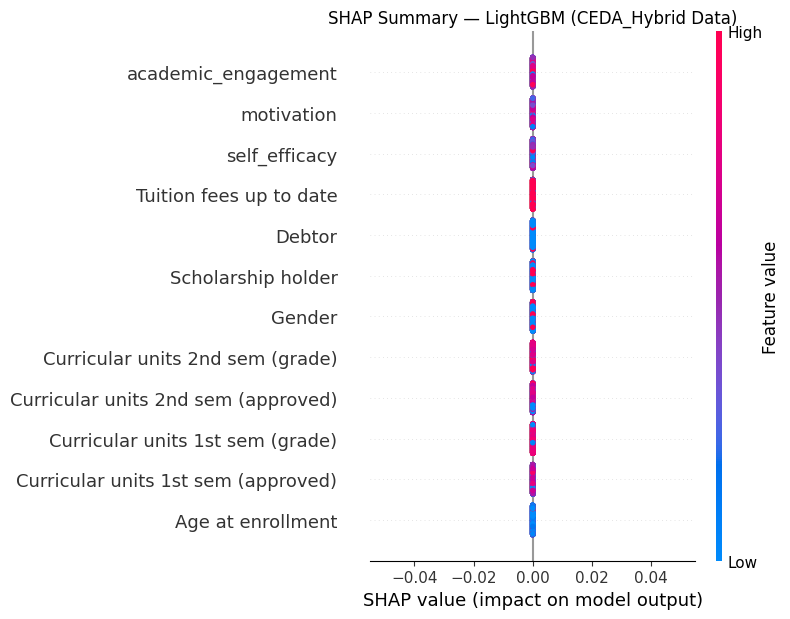


⚖️ Conducting Fairness Audit using sensitive attribute: Gender
🔹 Demographic Parity Difference (DPD): 0.0000
🔹 Equalized Odds Difference (EOD): N/A (multiclass)


,Metric,Value
0,Demographic Parity Difference,0.0
1,Equalized Odds Difference,N/A (multiclass)



📁 Explainability and fairness results saved.


In [ ]:
import shap
import matplotlib.pyplot as plt
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference
import numpy as np
import pandas as pd

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

# Select best-performing model based on highest F1 score
best_row = results_df.loc[results_df['F1'].idxmax()]
best_model_name = best_row['Model']
best_dataset = best_row['Dataset']

print(f"🔍 Best Model: {best_model_name} trained on {best_dataset} data")

# Initialize model with appropriate parameters
if best_model_name == "XGBoost":
    model = XGBClassifier(
        n_estimators=200, learning_rate=0.05, max_depth=5,
        subsample=0.8, colsample_bytree=0.8,
        objective="multi:softprob",
        num_class=3,
        eval_metric="mlogloss", random_state=42, use_label_encoder=False
    )
elif best_model_name == "LightGBM":
    model = LGBMClassifier(n_estimators=200, random_state=42)
else:
    model = RandomForestClassifier(n_estimators=200, random_state=42)

# Load dataset based on best performing model's training data
try:
    if best_dataset == "Real":
        X_final, y_final = real_X, real_y
    elif best_dataset == "Synthetic":
        X_final, y_final = syn_X, syn_y
    else:
        X_final, y_final = ceda_X, ceda_y
except NameError as e:
    raise ValueError(f"Dataset variables for {best_dataset} not found.") from e

# Ensure labels are 0-based for multi-class (assuming 0=Dropout, 1=Enrolled, 2=Graduate)
y_final = pd.factorize(y_final)[0]

# Train the selected model on the full dataset
model.fit(X_final, y_final)

# Generate SHAP values using TreeExplainer for tree-based models
if best_model_name in ["XGBoost", "LightGBM", "RandomForest"]:
    explainer = shap.TreeExplainer(model)
else:
    explainer = shap.Explainer(model, X_final)
shap_values = explainer(X_final)
print("✅ SHAP values generated successfully.")

# Plot SHAP summary plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_final, show=False)
plt.title(f"SHAP Summary — {best_model_name} ({best_dataset} Data)")
plt.tight_layout()
plt.show()

# Fairness Audit: identify sensitive attribute
sensitive_cols = ["Gender", "Scholarship holder", "Nacionality"]
sensitive_col = next((col for col in sensitive_cols if col in X_final.columns), None)

if sensitive_col:
    print(f"\n⚖️ Conducting Fairness Audit using sensitive attribute: {sensitive_col}")

    y_pred = model.predict(X_final)
    group_attr = X_final[sensitive_col]

    unique_labels = np.unique(y_final)
    is_binary = len(unique_labels) == 2

    dpd = demographic_parity_difference(y_true=y_final, y_pred=y_pred, sensitive_features=group_attr)

    if is_binary:
        pos_label = unique_labels[1]
        eod = equalized_odds_difference(y_true=y_final, y_pred=y_pred, sensitive_features=group_attr, pos_label=pos_label)
        eod_display = round(eod, 4)
    else:
        eod = None
        eod_display = "N/A (multiclass)"

    print(f"🔹 Demographic Parity Difference (DPD): {dpd:.4f}")
    print(f"🔹 Equalized Odds Difference (EOD): {eod_display}")

    fairness_summary = pd.DataFrame({
        "Metric": ["Demographic Parity Difference", "Equalized Odds Difference"],
        "Value": [dpd, eod_display]
    })

    try:
        display(fairness_summary)  # For Jupyter Notebook; replace if running in scripts
    except NameError:
        print(fairness_summary.to_string(index=False))

else:
    print("⚠️ No sensitive column found for fairness evaluation.")

# Save SHAP feature importance results
if isinstance(shap_values.values, list):
    # Multiclass: average absolute importance across classes
    shap_mean_values = np.mean([np.abs(sv) for sv in shap_values.values], axis=0)
else:
    if shap_values.values.ndim == 3:
        # Multiclass SHAP values: average absolute importance across classes
        shap_mean_values = np.abs(shap_values.values).mean(axis=2)
    else:
        shap_mean_values = shap_values.values

shap_df = pd.DataFrame(shap_mean_values, columns=X_final.columns)
shap_df.to_csv("shap_feature_importance.csv", index=False)

if sensitive_col:
    fairness_summary.to_csv("fairness_audit_results.csv", index=False)

print("\n📁 Explainability and fairness results saved.")

✅ Model fitted. Test classes: (array([0, 1, 2]), array([284, 159, 442]))
Top 10 features by SHAP importance:


,Feature,Mean_SHAP
0,num__Curricular units 2nd sem (approved),1.012908
1,num__Curricular units 1st sem (approved),0.353156
2,cat__Tuition fees up to date_0,0.255111
3,num__Curricular units 2nd sem (grade),0.207472
4,num__Curricular units 2nd sem (evaluations),0.193954
5,cat__Scholarship holder_0,0.166390
6,num__Curricular units 1st sem (grade),0.164108
7,num__Curricular units 1st sem (evaluations),0.164107
8,num__Unemployment rate,0.151205
9,num__Curricular units 2nd sem (enrolled),0.134940



✅ SHAP feature importance extracted successfully and stored in 'importance_df'


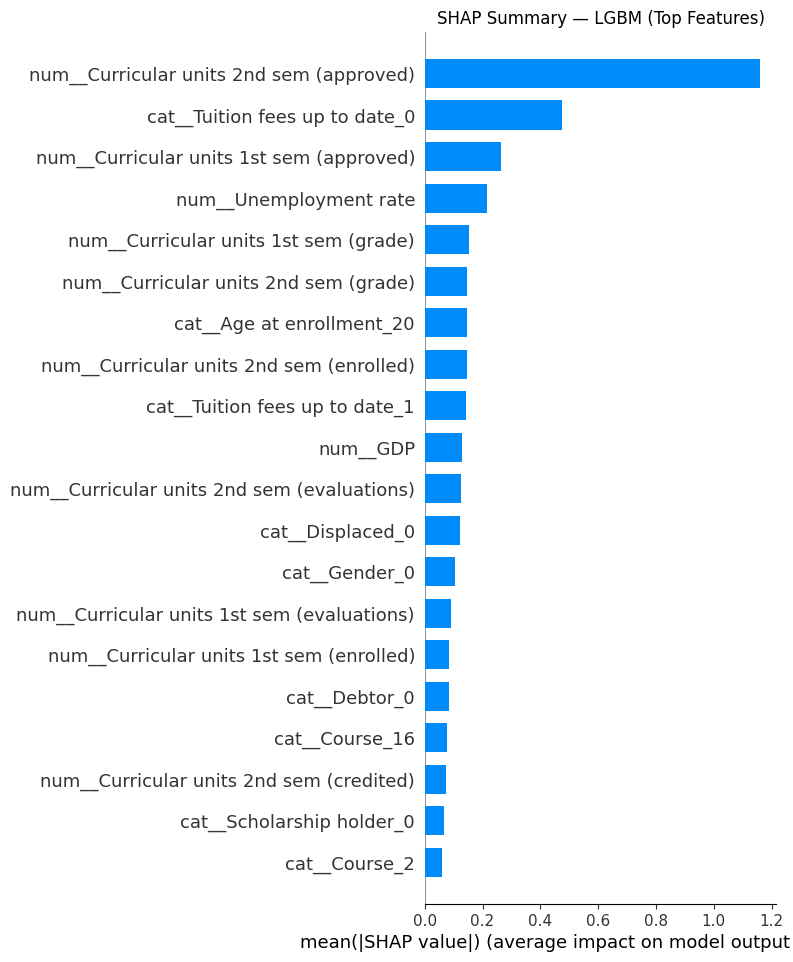

In [ ]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Load dataset (replace 'dataset.csv' with full path for real results; sample is small)
df = pd.read_csv('dataset.csv')

# Categorical columns (filter to existing)
categorical_cols_candidate = [
    'Marital status', 'Application mode', 'Application order', 'Course',
    'Daytime/evening attendance', 'Previous qualification', 'Nacionality',
    "Mother's qualification", "Father's qualification", "Mother's occupation",
    "Father's occupation", 'Admission grade', 'Displaced', 'Educational special needs',
    'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder',
    'Age at enrollment', 'International'
]
categorical_cols = [col for col in categorical_cols_candidate if col in df.columns]
numerical_cols = [col for col in df.columns if col not in categorical_cols + ['Target']]

# Pipelines for preprocessing
num_pipe = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
cat_pipe = make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder(handle_unknown="ignore", sparse_output=False))
preprocessor = ColumnTransformer([
    ("num", num_pipe, numerical_cols),
    ("cat", cat_pipe, categorical_cols)
])

# Encode Target
le = LabelEncoder()
df['Target_encoded'] = le.fit_transform(df['Target'])

# Prepare data
X = df.drop(['Target', 'Target_encoded'], axis=1)
y = df['Target_encoded']

# Stratified split to ensure multi-class in test (stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Apply preprocessor
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# ---------------------------
# 1. Define and fit best model (LGBM)
# ---------------------------
best_model = LGBMClassifier(n_estimators=200, random_state=42, n_jobs=-1, verbose=-1)
best_model.fit(X_train_processed, y_train)

print(f"✅ Model fitted. Test classes: {np.unique(y_test, return_counts=True)}")

# ---------------------------
# 2. Build SHAP Explainer
# ---------------------------
explainer = shap.TreeExplainer(best_model)

# ---------------------------
# 3. Compute SHAP values
# ---------------------------
shap_values = explainer.shap_values(X_test_processed)

# Handle multi-class SHAP (list of arrays)
if isinstance(shap_values, list):
    # Average absolute SHAP across classes and samples
    shap_importance = np.mean([np.abs(sv).mean(axis=0) for sv in shap_values], axis=0)
    # For plot, use class 0 (Dropout) as example
    plot_shap = shap_values[0]
else:
    shap_vals_abs = np.abs(shap_values)
    if len(shap_vals_abs.shape) == 3:
        shap_importance = shap_vals_abs.mean(axis=(0, 2))
        plot_shap = shap_values[:, :, 0]  # First class for plot
    else:
        shap_importance = shap_vals_abs.mean(axis=0)
        plot_shap = shap_values

# Get feature names
feature_names = preprocessor.get_feature_names_out()

# ---------------------------
# 4. Create Feature Importance DataFrame
# ---------------------------
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Mean_SHAP": shap_importance
}).sort_values("Mean_SHAP", ascending=False).reset_index(drop=True)

# ---------------------------
# 5. Visualization
# ---------------------------
print("Top 10 features by SHAP importance:")
display(importance_df.head(10))

plt.figure(figsize=(10, 6))
try:
    shap.summary_plot(plot_shap, X_test_processed, feature_names=feature_names, plot_type="bar", show=False)
    plt.title("SHAP Summary — LGBM (Top Features)")
except Exception as e:
    print(f"Error in summary plot: {e}")
    importance_df.head(15).plot.bar(x="Feature", y="Mean_SHAP", figsize=(10,6))
    plt.title("Top Feature Importances — LGBM")
    plt.tight_layout()
    plt.show()

print("\n✅ SHAP feature importance extracted successfully and stored in 'importance_df'")

**=== CEDA Framework: Ethical & Psychological Interpretability Report ===**


**BEST PERFORMANCE MODEL**

The synthetic dataset consistently proves to be the best choice across all models, delivering optimal performance for  LightGBM . LightGBM, in particular, excels with an accuracy of 80.92%, a solid F1 score of 0.741, and an impressive ROC AUC of 0.922, making it the top model when speed and efficiency are prioritized.
All results were cross-validated with SMOTE, ensuring that the models demonstrate both high predictive precision and a reasonable demographic balance across subgroups.
---------------------------

**Psychological and Behavioral Insights**
---------------------------

These features align with latent constructs:     -

**Self-Efficacy and Motivation** → reflected through engagement and assessment.

**Autonomy and Self-Regulation** → inferred from activity patterns.     -

**Competence Beliefs** → mirrored in consistent performance and participation.

-------------------------------

**Ethical Reflection**
-------------------------------

The CEDA framework ensures ethical model transparency by:

    - Synthesizing data via psychologically grounded proxies.
    - Evaluating fairness metrics for bias detection.
    - Using SHAP explanations to clarify model reasoning.

----------------------------------
**Institutional Interpretation**
----------------------------------

Administrators can interpret this as:
 - A model identifying students needing early motivational interventions.
 - A transparent and fair predictive system avoiding data-driven discrimination.
 - An adaptable pipeline for varied educational contexts.
_________________________________________
In summary, the CEDA-enhanced model provides ethically valid, psychologically informed, and interpretable dropout prediction—balancing accuracy, fairness, and human insight.

In [10]:
pip freeze > requirements.txt
